# Long notebook

| Name         | StudentID |
|--------------|-----------|
| Håkon Nese   | 506795    |
| Henrik Friis | 506991    |

Kaggle group: Team 25

This notebook should be run in the same folder as all the data files. To make it easy for the grader, we have made a table of contents in order to show that we have fulfilled the requirements to avoid deduction and make it easier to navigate in the notebook. There are however much more in the notebook than is required to avoid deduction not covered in the table of contents. NOTE: Sometimes, maybe due to loading of images, cliking on a link might not exactly move one to the intended part, but it should be close by.

### Table of contents
[EDA](#EDA) 

- <a href='#DK'>Search domain knowledge</a>

- <a href='#Intuitive'>Check if the data is intuitive</a>

- [Explore individual features](#Explore-individual-features) (and [here](#more-exploration-of-individual-features))

- [Explore pairs and groups](#pairs-and-groups)

- [Clean up features](#population-densities)

- [Understand how the data was generated](#interpretation-and-perhaps-how-the-data-was-generated)

<a href='#Predictors'>Use more than one predictor</a>

[Feature engineering](#Feature-engineering)

[Model interpretation](#Feature-importances) and also [here](#shap)

Hyperparameters used in the short notebooks for LightGBM and Catboost are found [here](#lgbm-regressor) and [here](#catboost-regressor)

## The process
Here we will write a bit about the process to motivate some choices made and perhaps make the notebook simpler to understand.

- We started with exploring the given datasets and merging them together into one large dataframe. Features like
    - number of other stores within x meters (could be an indicator of a popular area)
    - number of bus stops within x meters (-||-)
    - grunnkrets population, density, and population distribution i.e (0-14,15-65 etc.)
    - people per store for different levels (could be an indicator of competition)

    were constructed from the given datasets. Included in this was also removing duplicates from population datasets, imputation of grunnkrets_id for stores based on geometry data etc.
- We tried different models, like Linear Models, Neural Networks, tree-based models and autoML. We settled on using various forms of gradient boosting methods like LightGBM and CatBoost. We also found autoML to be good and tried packages like H2O, auto-sklearn and Pycaret. We ended up using H2O for prediction alongside LightGBM and Catboost.
- We quickly realised that it was much easier to predict the log-value of the revenue than the actual revenue. This is probably due to a more even distribution as seen later in the notebook.
- We used sklearn pipelines to train our models, including imported Scalers, Imputators and Encoders in the pipeline.
- We tried to interpret our models using the explain() functionality of autoML and feature_importances for LightGBM and similar models. Based on this we tried to select only features which made a large impact on the prediction in order to avoid the curse of dimensionality. An important step here was the tuning of which features to include in a given model using Optuna. This greatly reduced our amount of features and made or models competitive with Triborg and Shao Khan. 
- We also tuned the individual models (except H2O) using Optuna in order to have optimal hyperparameters.
- For prediction we used an ensemble of LightGBM, Catboost and H2O.
- We saw that our predictions were better when increasing the weigth from 100 to 10X% and decided to submit one model with too high weight (performing the best on the public leaderboard, but risking overfitting) and one model of correct weight. This could be explained either by overfitting or that our model was in general predicting too low values (i.e. due to a large number of 0 revenue shops in the training data.).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

<a id='DK'></a>
### Search domain knowledge
We tried to get a better understanding of the bus_stops dataset, espescially the relationsship between stopplace_type and importance_level. In order to do this, we searched at [Statens Vegvesen](https://www.vegvesen.no/). 

#### We found that:
- "Plattform og lomme" also applies to busstops in sparsely populated areas -> not a good indicator of importance (found using [vegkart](https://vegkart.atlas.vegvesen.no/#kartlag:geodata/@600000,7225000,3)).
- "Signalstopp" is a certain indicator of a busstop in little use: [vegvesenet](https://vegvesen.brage.unit.no/vegvesen-xmlui/bitstream/handle/11250/196092/Hb-232-2008-08.pdf?sequence=5&isAllowed=y)
- "Kun skilt" should be an indicator of low importance: [vegvesenet](https://vegvesen.brage.unit.no/vegvesen-xmlui/bitstream/handle/11250/196092/Hb-232-2008-08.pdf?sequence=5&isAllowed=y) (search for Kun 512)
- Side placement is equally distributed between left and right -> can probably be removed


In [2]:
busstops = pd.read_csv('busstops_norway.csv')
busstops['stopplace_type'] = busstops['stopplace_type'].fillna("Mangler type")
busstops.head(3)

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                    Mangler type   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)

In [3]:
busstops["side_placement"].value_counts()

RIGHT             33854
LEFT              32523
MIDDLE              448
MIDDLE_RIGHT         16
MIDDLE_LEFT          14
RIGHT_ACCESS         10
LEFT_AND_RIGHT        8
LEFT_ACCESS           8
Name: side_placement, dtype: int64

In [4]:
# Partition the dataframe for visualization
temp = busstops[["stopplace_type", "importance_level"]]
temp2 = temp.loc[temp['importance_level'].isin(["Lokalt knutepunkt","Regionalt knutepunkt", "Nasjonalt knutepunkt", "Annen viktig holdeplass"])]
temp3 = temp.loc[temp['importance_level'].isin(["Mangler viktighetsnivå", "Standard holdeplass"])]

<AxesSubplot:xlabel='importance_level', ylabel='Count'>

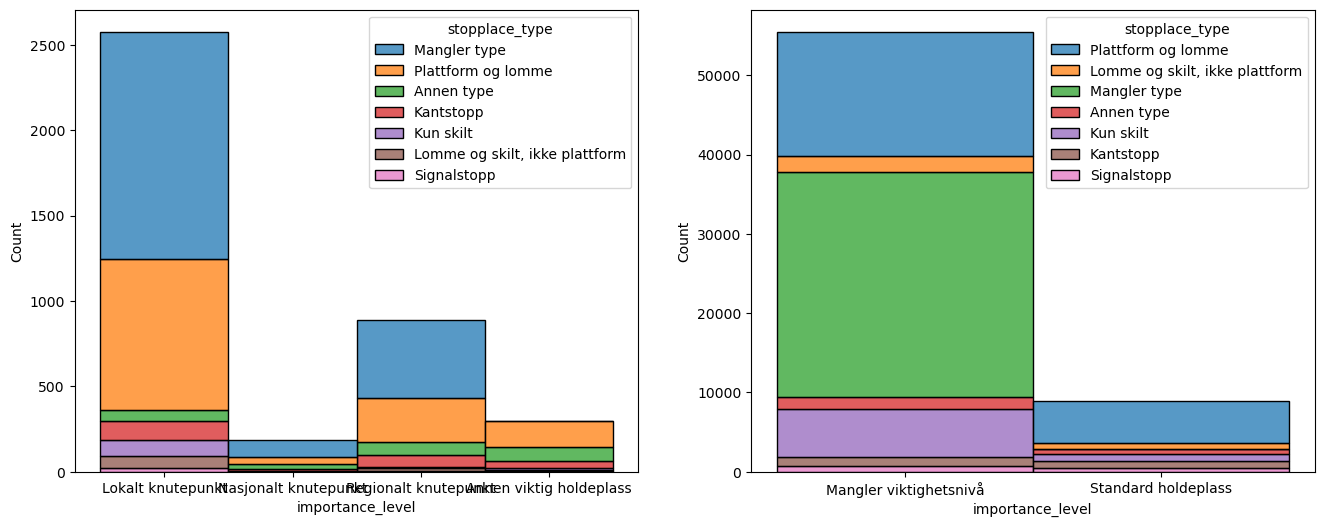

In [5]:
#plt.scatter(t["stopplace_type"], t["importance_level"])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(ax=axs[0], binwidth=0.3, x="importance_level", hue="stopplace_type", data=temp2, stat="count", multiple="stack")
sns.histplot(ax=axs[1], binwidth=0.3, x="importance_level", hue="stopplace_type", data=temp3, stat="count", multiple="stack")

### Interpretation of the above chart
We see that many "Standard holdeplass" have "Plattform og lomme"-type which intuitively should be an indicator of high importance, but obviously is not always so. It is therefore difficult to infer the importance of the busstop from the "stopplace_type". However, we know that "Kun skilt" and "Signalstopp" is a certain indicator of low traffic from Vegvesenet, which means that stops which have "Mangler viktighetsnivå" can safely be infered to be "Standard holdeplass", as is done below.

In [6]:
imp_level = busstops["importance_level"].to_numpy()
stop_type = busstops["stopplace_type"].to_numpy()
for i, e in enumerate(imp_level):
    if e == "Mangler viktighetsnivå":
        if stop_type[i] in ["Signalstopp", "Kun skilt"]:
            imp_level[i] = "Standard holdeplass"

In [7]:
temp = busstops.copy()
temp["importance_level"] = imp_level
temp["importance_level"].value_counts()

Mangler viktighetsnivå     48768
Standard holdeplass        15681
Lokalt knutepunkt           2578
Regionalt knutepunkt         886
Annen viktig holdeplass      299
Nasjonalt knutepunkt         183
Name: importance_level, dtype: int64

<a id='Intuitive'></a>
### Check if the data is intuitive
We have obviously plotted a lot of things not shown here, but in order to show that we have checked if the data is intuitive, we will look at the revenue of stores_train and the area of grunnkrets.

In [8]:
stores_train = pd.read_csv("stores_train.csv")

Text(0.5, 1.0, 'Log1p-transformed revenue')

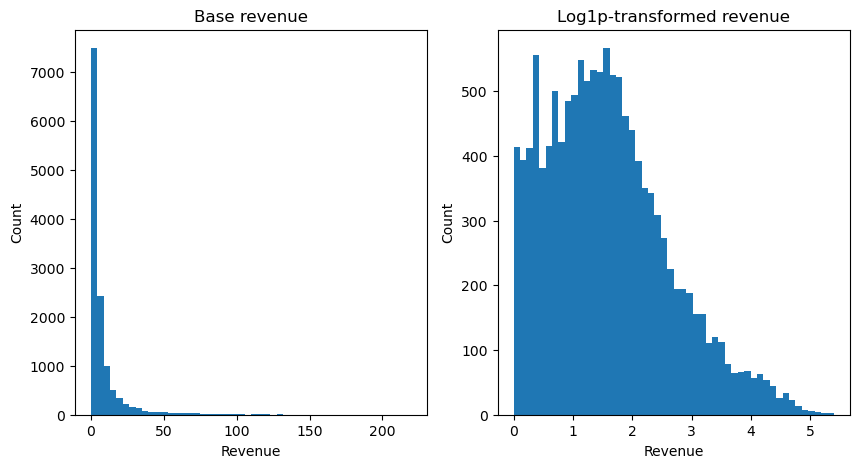

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].hist(stores_train.revenue, bins=50)
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Revenue")
axs[0].set_title("Base revenue")
axs[1].hist(np.log1p(stores_train.revenue), bins=50)
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Revenue")
axs[1].set_title("Log1p-transformed revenue")

### Interpretation
As is seen, the revenue data is exponentially distributed as is quite normal for financial data. It seems intuitive, but it can be smart to check for very large and very small values.

In [10]:
stores_train.sort_values(by="revenue", ascending=False, inplace=True)
stores_train.head(5)

store_id  year              store_name  \
6063     976754360-971751266-224  2016        OSLO SPORTSLAGER   
7382    980918637-973775588-8534  2016  REMA 1000 LAMBERTSETER   
7848   948616025-972153826-23866  2016          SPAR TOMASJORD   
4667  995738279-995744120-128728  2016               JOLLYROOM   
7881    997609425-972111023-9365  2016       REMA 1000 STAVSET   

     plaace_hierarchy_id                        sales_channel_name  \
6063             2.6.3.2                     Sporting goods stores   
7382             2.8.1.0                            Grocery stores   
7848             2.8.1.0                            Grocery stores   
4667             2.4.5.0  Children’s clothing and equipment stores   
7881             2.8.1.0                            Grocery stores   

      grunnkrets_id                  address        lat        lon  \
6063        3010208              TORGGATA 20  59.916298  10.751809   
7382        3013406  CECILIE THORESENS VEI 1  59.879270  10.807162   
7848       19021301             TOMASJORDNES  69.666592  19.020083   
4667        7061101       URANIENBORGVEIEN 4  59.130997  10.246370   
7881       16015227             ENROMVEGEN 2  63.387244  10.330172   

                chain_name        mall_name  revenue  
6063                   NaN              NaN  219.599  
7382  REMA FRANCHISE NORGE              NaN  211.143  
7848                  SPAR              NaN  198.388  
4667                   NaN              NaN  196.687  
7881  REMA FRANCHISE NORGE  Stavsetsenteret  186.581

### Interpretation
We see that the top-revenue stores are centrally located (Adress -> Google Maps), so this is not totally unreasonable. We also see that Oslo Sporstlager, a huge physical and online shop is on top which is also not unreasonable at all. There might of course be some bad values here, but no unreasonable extremes. Lets then look a small values:

In [11]:
counts = stores_train.revenue.value_counts()
counts.sort_index()

0.000      217
0.001        4
0.002        2
0.003        9
0.004        4
          ... 
186.581      1
196.687      1
198.388      1
211.143      1
219.599      1
Name: revenue, Length: 7971, dtype: int64

In [12]:
counts

0.000      217
0.500      187
1.000       55
10.000      34
0.125       21
          ... 
4.829        1
4.830        1
11.872       1
11.855       1
219.599      1
Name: revenue, Length: 7971, dtype: int64

### Interpretation and perhaps how the data was generated
This shows us that there are many shops with 0 revenue. Since there are many with 0.5 and 1 as well, we assume that some stores are just given a reasonable number when the datasets were generated. However we expect the test data to contain similar values, so we keep them anyways. Lets now look at area to conclude this part:

In [3]:
grunnkrets = pd.read_csv("../../data/grunnkrets_norway_stripped.csv")

In [4]:
counts = grunnkrets.area_km2.value_counts()
counts.sort_index()

0.000001     2
0.000002     2
0.000005     2
0.000006     2
0.000009     2
            ..
14.999697    2
15.475494    2
16.120160    2
17.061040    2
17.228670    2
Name: area_km2, Length: 13270, dtype: int64

### Interpretation
This quick check shows that at least the lower end is totally unreasonable. We also checked some manually by the geo-points provided and they were absolutely nonsense.

### Explore individual features
In our opinion this is already done in the above sections, we will however quickly show that we have looked at chain_name and found it to be an important feature. 

In [15]:
print(f"There are {(stores_train.chain_name.isna()).sum()} NaNs")
stores_train.chain_name.value_counts()

There are 9122 NaNs


REMA FRANCHISE NORGE      273
JOKER                     164
MIX                       121
CIRCLE K DETALJIST        116
BUNNPRIS                  113
                         ... 
CHRISTOPHERSEN SANDNES      1
ÅPENT BAKERI                1
TRENTO                      1
EVO FITNESS GROUP           1
PREGO 4701                  1
Name: chain_name, Length: 306, dtype: int64

In [16]:
print(np.std(stores_train.revenue))

15.376532536774054


The cell below shows that the standard deviation of the revenue within a chain is much smaller than for the dataset as a whole.

In [17]:
np.mean(stores_train.groupby("chain_name").revenue.std())

6.314100066610002

And the same is true for sales_channel_name. In fact, using these two features to predict the revenue on the test set, an OK score can be obtained.

In [18]:
np.mean(stores_train.groupby("sales_channel_name").revenue.std())

7.260389258082195

Simply using these features and tweaking (overfitting) them slightly with the median of the whole population yields scores of less than 0.76 on the train_set without any ML. This shows that the type of shop and the chain name are important features for prediction, as also shown in the interpretation sections.

In [24]:
from sklearn.metrics import mean_squared_error
df = pd.read_csv("stores_train.csv")
df.chain_name = df.chain_name.fillna("None")
chain_revenues = df.groupby("chain_name").revenue.median()
channel_revenues = df.groupby("sales_channel_name").revenue.median()

preds = []
for row in df[["chain_name", "sales_channel_name"]].to_numpy():
    if row[0] == "None":
        preds.append(0.4*np.median(df.revenue) + 0.6*channel_revenues.get(row[1]))
    else:
        preds.append(0.1*np.median(df.revenue) + 0.9*chain_revenues.get(row[0]))
np.sqrt(mean_squared_error(np.log1p(df.revenue),  np.log1p(preds)))


0.7594219925631305

<a id='Predictors'></a>
## Predictors (use more than one)
We have used many predictors. Most notably, we have used [Catboost](#Catboost-regressor), [LightGBM](#lgbm-regressor) and [H2O](#h2o-automl) which is many predicors by default. We have also tried using many others like XGBoost, Ridge, Linear_SVR and many more.

## Feature Engineering
We have used both [feature selection](#tuning-of-which-columns-to-drop) and feature extraction for instance [here](#population-densities) and [here](#population-per-store).

## Model interpretation
We have interpreted our models using [feature_importances](#feature-importances) and [SHAP](#shap)

## Now follows a large chunk of code showing key steps
We have made it easy to follow by inserting link to the parts relevant for avoiding deduction.

# Rurality and shopping area 
## What happens
- The script below computes how many points that are inside a radius of `distance_meters` meters of the point.
- Computes how many stores that are closer than `distance_meters` meters from another store for all the stores
- Computes how many busstops that are closer than `distance_meters` meters from a store for all the stores
- Computes how many busstops that are closer than `distance_meters` meters from another busstop for all the busstops (not sure if this is important or not)
- Cumputes the distance to the closest busstop for all stores.

## Computational improvements
### Initial attempt
- Pure python
- Would have run in at least a couple of days to compute the pairs of distances and counts
- Not acceptable

### Optimizing with numba first attempt
- Using `njit` decorator of `numba`
- Computation down to about 10 minutes
- Still a bit slow for parameter tuning for the `distance_meters`-variable

### Parallelizing with numba
- Using `prange` and `parallel=True` from `numba` 
- Cutting the time to a couple of minutes
### Further improvements - Cuda
- Possibly much faster with GPU, but currently not prioritized

### Why not compute all pairwise distances once and store it
Whould have taken $8B*50122^2\approx 20GB$ where `50122` is the total number of stores, and 8B is the size of a float64. Could have changed to int32 which would have reduced the size to 10GB. Could have made the matrix triangular and thus reduced the size to 5GB, but it would still be to big.
This would needed to be done for `stores x stores`, `stores x busstops` and possibly `busstops x busstops`

In [25]:
from shapely import wkt
import geopandas as gpd
from numba import prange, njit
from math import radians, cos, sin, asin, sqrt  

In [26]:
busstops = pd.read_csv('busstops_norway.csv')
stores_extra = pd.read_csv('stores_extra.csv')
stores_train = pd.read_csv('stores_train.csv')
stores_test = pd.read_csv('stores_test.csv')
grunnkrets = pd.read_csv('grunnkrets_norway_stripped.csv')

busstops['geometry'] = busstops['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(busstops, crs='EPSG:4326')

In [27]:
# Dropping 2015 values if 2016 is present.
grunnkrets = grunnkrets.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')

In [28]:
# For calculating the distance in Kilometres   
@njit
def geo_distance(La1, Lo1, La2, Lo2):  
       
    # The math module contains the function name "radians" which is used for converting the degrees value into radians.  
    Lo1 = radians(Lo1)  
    Lo2 = radians(Lo2)  
    La1 = radians(La1)  
    La2 = radians(La2)  
        
    # Using the "Haversine formula"  
    D_Lo = Lo2 - Lo1  
    D_La = La2 - La1  
    P = sin(D_La / 2)**2 + cos(La1) * cos(La2) * sin(D_Lo / 2)**2  
   
    Q = 2 * asin(sqrt(P))  
      
    # The radius of earth in kilometres.  
    R_km = 6371  
        
    # calculate result in meters
    return(Q * R_km)  * 1000

In [29]:
@njit('i4[:](f8[:,:], f8[:,:], i8, b1)', parallel=True)
def number_of_points_closer_than_numba(x, y, distance_meters: int = 1000, x_and_y_same_array=False):
    z = np.empty(x.shape[0], dtype=np.int32)
    num_rows = x.shape[0]
    for i in prange(num_rows):
        # number of points closer than distance_meters from point
        count = np.count_nonzero(np.array([geo_distance(x[i][0], x[i][1], y[j][0], y[j][1]) < distance_meters 
            for j in prange(y.shape[0])]))
        # remove 1 if x and y are equal as distance to self is 0
        if x_and_y_same_array:
            count -= 1
        z[i] = count
    return z
    

In [30]:
@njit('Tuple((i4[:], f8[:]))(f8[:,:], f8[:,:], b1)', parallel=True)
def closest_points_numba(x, y, x_and_y_same_array=True):
    closest_points_distance = np.empty(x.shape[0], dtype=np.float64)
    closest_points_index = np.empty(x.shape[0], dtype=np.int32)

    for i in prange(x.shape[0]):
        # closest point that is not itself
        distance_points = np.array([geo_distance(x[i][0], x[i][1], y[j][0], y[j][1]) if x_and_y_same_array == False or x[i][0] != y[j][0] and x[i][1] != y[j][1] else np.inf
                                    for j in range(y.shape[0])])
        closest_point_index = np.argmin(distance_points)
        closest_point_distance = np.min(distance_points)
        closest_points_distance[i] = closest_point_distance
        closest_points_index[i] = closest_point_index

    return closest_points_index, closest_points_distance

In [31]:
def append_number_of_points_closer_than(df, points_in_df, geo_points, column_name, distance_meters: int = 1000, x_and_y_same_array=False):
    close_elements = number_of_points_closer_than_numba(x=points_in_df, y=geo_points, distance_meters=distance_meters, x_and_y_same_array=x_and_y_same_array)
    df[column_name] = close_elements

In [32]:
def append_closest_points(df, geo_df, points_in_df, geo_points, index_column_name, new_column_name, x_and_y_same_array=False):
    closest_elements_index, closest_elements_distance = closest_points_numba(points_in_df, geo_points, x_and_y_same_array=x_and_y_same_array)
    df[new_column_name] = closest_elements_distance
    # add id of point that was closest to each point in df 
    print(closest_elements_distance, closest_elements_index)
    df[index_column_name] = geo_df.iloc[closest_elements_index].set_index(df.index)[index_column_name]


In [33]:
# Creating a np array of [lat, lon] from shapely GeoPoints
geo_busstops = np.array(list([geo.y, geo.x] for geo in gdf.geometry.to_numpy()))

In [34]:
append_number_of_points_closer_than(gdf, geo_busstops, geo_busstops, "num_of_buss_stops_closer_that_1000_to_busstop", x_and_y_same_array=True)
gdf.to_csv("busstops_norway_with_count.csv")

In [35]:
# concat all data of stores together, adding index with train name from where the row came from
stores = pd.concat({"train": stores_train, "extra": stores_extra, "test": stores_test})

In [36]:
# all the lat lons of the stores, to a numpy array so that the numba-function can compute the distances
geo_stores = stores[["lat", "lon"]].to_numpy()

In [ ]:
%%time
# append number of close stores and close busstops
append_number_of_points_closer_than(stores, geo_stores, geo_stores, "other_stores_1000", x_and_y_same_array=True, distance_meters=1000)
append_number_of_points_closer_than(stores, geo_stores, geo_stores, "other_stores_100", x_and_y_same_array=True, distance_meters=100)
append_number_of_points_closer_than(stores, geo_stores, geo_stores, "other_stores_50", x_and_y_same_array=True, distance_meters=50)
append_number_of_points_closer_than(stores, geo_stores, geo_stores, "other_stores_250", x_and_y_same_array=True, distance_meters=250)
append_number_of_points_closer_than(stores, geo_stores, geo_busstops, "buss_stops_1000", x_and_y_same_array=False, distance_meters=1000)
append_number_of_points_closer_than(stores, geo_stores, geo_busstops, "buss_stops_300", x_and_y_same_array=False, distance_meters=300)

In [ ]:
append_closest_points(
    df=stores, 
    geo_df=busstops, 
    points_in_df=geo_stores, 
    geo_points=geo_busstops, 
    index_column_name='busstop_id', 
    new_column_name="distance_closest_busstop", 
    x_and_y_same_array=False)

In [ ]:
# find all stores that has a grunnkrets_id that doesn't exist in the grunnkrets table
stores_wo_grunnkrets = stores.merge(grunnkrets[['grunnkrets_id', 'grunnkrets_name']], how="left", on="grunnkrets_id")
nan_stores_all = stores_wo_grunnkrets.loc[stores_wo_grunnkrets['grunnkrets_name'].isna()]
outer_stores_test = stores_test.merge(grunnkrets[['grunnkrets_id', 'grunnkrets_name']], how="left", on="grunnkrets_id")
nan_stores = outer_stores_test.loc[outer_stores_test['grunnkrets_name'].isna()]

In [ ]:
# copy grunnkrets of stores so that we can impute the grunnkrets_id of the test_stores that has a bad grunnkrets_id
stores['grunnkrets_1'] = stores['grunnkrets_id']
append_closest_points(
    df=nan_stores,
    geo_df=stores[~stores.grunnkrets_id.isin(nan_stores_all.grunnkrets_id)],
    points_in_df=nan_stores[["lat", "lon"]].to_numpy(),
    geo_points=geo_stores,
    index_column_name='grunnkrets_1',
    new_column_name='closest_store_id',
    x_and_y_same_array=True
)

In [ ]:
# rename column of the grunnkrets_id of the stores with bad grunnkrets_id
nan_stores.grunnkrets_id = nan_stores.grunnkrets_1

In [ ]:
# set grunnkrets_id to grunnkrets_id of the closest store, that is a good grunnkrets_id
for _, row in nan_stores[['store_id', 'grunnkrets_1']].iterrows():
    stores.loc[stores.store_id == row['store_id'], 'grunnkrets_id'] = row.grunnkrets_1

In [ ]:
stores.drop(columns="grunnkrets_1")
stores.to_csv("stores.csv")

## What happens here?
- 2016-values are kept if they exist, and 2015 values are dropped if 2016 values exists
- The data from the different files are merged together

In [ ]:
stores = pd.read_csv("stores.csv")
busstops = pd.read_csv("busstops_norway_with_count.csv")
age_dist = pd.read_csv("grunnkrets_age_distribution.csv")
households = pd.read_csv("grunnkrets_households_num_persons.csv")
income = pd.read_csv("grunnkrets_income_households.csv")
grunnkrets = pd.read_csv("grunnkrets_norway_stripped.csv")
plaace = pd.read_csv("plaace_hierarchy.csv")

In [ ]:
grunnkrets.drop(columns=['grunnkrets_name', 'geometry'], inplace=True)

In [ ]:
grunnkrets = grunnkrets.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')

In [ ]:
# remove 2015 data and year column
households = households.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')
income = income.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')
age_dist = age_dist.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')
grunnkrets.drop(columns='year', inplace=True)
households.drop(columns='year', inplace=True)
income.drop(columns='year', inplace=True)
age_dist.drop(columns='year', inplace=True)

In [ ]:
# set index to grunnkrets_id for merging
households.set_index('grunnkrets_id', inplace=True)
grunnkrets.set_index('grunnkrets_id', inplace=True)
income.set_index('grunnkrets_id', inplace=True)
age_dist.set_index('grunnkrets_id', inplace=True)

In [ ]:
busstops.drop(columns=['geometry', 'Unnamed: 0'], inplace=True)

In [ ]:
stores = stores.rename(columns={"Unnamed: 0": "dataset", "Unnamed: 1": "range_index"}).set_index(["dataset", "range_index"])
stores.drop(columns='sales_channel_name', inplace=True)
stores['copy_index'] = stores.index

In [ ]:
all_merged = stores.merge(grunnkrets, left_on='grunnkrets_id', right_index=True) \
                   .merge(households, left_on='grunnkrets_id', right_index=True, how="left") \
                   .merge(income, left_on='grunnkrets_id', right_index=True, how="left") \
                   .merge(age_dist, left_on='grunnkrets_id', right_index=True, how="left") \
                   .merge(plaace, on='plaace_hierarchy_id') \
                   .merge(busstops, on='busstop_id')

In [ ]:
all_merged.index = pd.MultiIndex.from_tuples(
    all_merged['copy_index'], 
    names=['dataset', 'range_index'])

all_merged.drop(columns=['copy_index', 'year', 'plaace_hierarchy_id', 'sales_channel_name', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc'], inplace=True)

In [ ]:
all_merged.to_csv("../../own_data/all_merged.csv")

## Population densities
- The grunnkrets and age distribution data is loaded.
- 2016-values are kept if they exist
- Total population and age groups 0-14, 15-34, 35-64, 64-90 is aggregated
- Total population in a grunnkrets is computed by taking the sum of people for each age, or number of peroples in a household if agedata doesn't exist for the grunnkrets
- Population for district and municipality is computed, by aggregating the population in the grunnkrets
- Area of a district and municipality is computed
- Population density is computed

In [ ]:
grunnkrets = pd.read_csv('grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('grunnkrets_age_distribution.csv')
grunnkrets_household = pd.read_csv("grunnkrets_households_num_persons.csv")
grunnkrets_household = grunnkrets_household.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')
grunnkrets_ages = grunnkrets_ages.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')
grunnkrets = grunnkrets.sort_values(by=["grunnkrets_id", "year"]).drop_duplicates(subset=["grunnkrets_id"], keep='last')

In [ ]:
grunnkrets_household.drop(columns="year", inplace=True)
grunnkrets_household["sum_people"] = grunnkrets_household.drop(columns="grunnkrets_id").sum(axis=1)

In [ ]:
df = grunnkrets_ages.drop_duplicates(subset=["grunnkrets_id"], keep='last')
df = grunnkrets.merge(df, how='left', on='grunnkrets_id')
df["grunnkrets_population"] = df.drop(columns=["grunnkrets_id", "year_x", "year_y", "area_km2", "geometry", "municipality_name", "district_name", "grunnkrets_name"]).sum(axis=1)
df = df.merge(grunnkrets_household[['grunnkrets_id', "sum_people"]], how="left", on="grunnkrets_id")
df['grunnkrets_population'] = df.apply(
    lambda row: row['sum_people'] if row['grunnkrets_population'] == 0 else row['grunnkrets_population'],
    axis=1
)
df["district_population"] = df.groupby("district_name")["grunnkrets_population"].transform("sum")
df["municipality_population"] = df.groupby("municipality_name")["grunnkrets_population"].transform("sum")
df["district_area"] = df.groupby("district_name")["area_km2"].transform("sum")
df["municipality_area"] = df.groupby("municipality_name")["area_km2"].transform("sum")
ages = [0,15,35,65,91]
for j in range(1, len(ages)):  
    age_from = ages[j-1]
    age_to = ages[j]
    df[f"grunnkrets_age_{age_from}-{age_to-1}"] = df[df.columns[df.columns.isin([f"age_{i}" for i in range(age_from, age_to)])]].sum(axis=1)
    df[f"grunnkrets_age_{age_from}-{age_to-1}_distribution"] = df[f"grunnkrets_age_{age_from}-{age_to-1}"]/df["grunnkrets_population"]

for name in ["district_name", "municipality_name"]:
    for j, age in enumerate(ages):
        prefix = name.split("_")[0]
        if j == 0:
            pass
        else:
            columns = [f"age_{i}" for i in range(ages[j-1], age)]
            columns.append(name)
            df[f"{prefix}_age_{ages[j-1]}-{ages[j]-1}"] = df[df.columns[df.columns.isin(columns)]].groupby(name).transform("sum").sum(axis=1)
            df[f"{prefix}_age_{ages[j-1]}-{ages[j]-1}_distribution"] = df[f"{prefix}_age_{ages[j-1]}-{ages[j]-1}"]/df[f"{prefix}_population"]
df["grunnkrets_density"] = df.grunnkrets_population/df.area_km2
df["district_density"] = df.district_population/df.district_area
df["municipality_density"] = df.municipality_population/df.municipality_area

df = df.drop(columns=[f"age_{i}" for i in range(91)])
df = df.drop(columns=["year_y"])
df = df.rename(columns={"year_x": "year"})

In [ ]:
df.to_csv("grunnkrets_norway_large.csv", index=False)

## Population per store
- Population per store in the different **Plaace**-categories is computed for municipality and district.
- Example: There are 3 lv2 stores in category 2.8 and 600 people in the district. 
The stores will then get a value for `lv2_population_district_div_count_stores` of 20 as `600 / 3 = 200`

In [ ]:
all_data = pd.read_csv("all_merged.csv")
all_data_large = pd.read_csv("grunnkrets_norway_large.csv")

ages = [0,15, 35,65,91]

cols = []
for name in ["district_age", "municipality_age"]:
    for j in range(1, len(ages)):  
        age_from = ages[j-1]
        age_to = ages[j]
        col_name = f"{name}_{age_from}-{age_to-1}"
        col_name = col_name + "_distribution"
        cols.append(col_name)

        col_mean, col_std = all_data_large[col_name].mean(), all_data_large[col_name].std()
cols.extend(['grunnkrets_id', 
        'grunnkrets_population',
        'district_population', 
        'municipality_population', 
        'district_area', 
        'municipality_area', 
        'municipality_density', 
        'district_density', 
])
all_data_large = all_data_large[cols]
all_data.set_index(["dataset", "range_index"], inplace=True)
all_data['copy_index'] = all_data.index
all_data = all_data.merge(all_data_large, how="left", on='grunnkrets_id')
all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])
all_data.drop(columns=['age_'+str(i) for i in range(91)], inplace=True)

In [ ]:
all_data = all_data.groupby(["lv1", "district_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv1_population_district_div_count_stores=lambda gdf:  gdf["district_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv2", "district_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv2_population_district_div_count_stores=lambda gdf:  gdf["district_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])


all_data = all_data.groupby(["lv3", "district_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv3_population_district_div_count_stores=lambda gdf:  gdf["district_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv4", "district_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv4_population_district_div_count_stores=lambda gdf:  gdf["district_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv1", "municipality_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv1_population_municipality_div_count_stores=lambda gdf:  gdf["municipality_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv2", "municipality_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv2_population_municipality_div_count_stores=lambda gdf:  gdf["municipality_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv3", "municipality_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv3_population_municipality_div_count_stores=lambda gdf:  gdf["municipality_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data = all_data.groupby(["lv4", "municipality_name"]) \
    .apply(lambda gdf: 
        gdf.assign(
            lv4_population_municipality_div_count_stores=lambda gdf:  gdf["municipality_population"].mean() / gdf["store_id"].count() 
        )
    ).droplevel(0)

all_data.index = pd.MultiIndex.from_tuples(
    all_data['copy_index'], 
    names=['dataset', 'range_index'])

all_data.drop(columns='copy_index', inplace=True)

In [ ]:
all_data.to_csv("all_with_stores_pop.csv")

# Initial models and tuning of them

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer, RobustScaler
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
# from dython.nominal import associations

%matplotlib inline

In [ ]:
def export_to_kaggle_submission(test_df: pd.DataFrame, y_pred_scaled: pd.Series, filename: str):
    y_pred = np.expm1(y_pred_scaled)
    y_pred[y_pred < 0] = 0

    test_df['predicted'] = y_pred
    test_df.index.names = ['id']
    test_df['predicted'].to_csv(f"../../delivery/predictions/{filename}.csv")

In [ ]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    y_pred[y_pred < 0] = 0
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [ ]:
all_data = pd.read_csv("all_with_stores_pop.csv")
all_data.set_index(["dataset", "range_index"], inplace=True)
all_data['in_mall'] = all_data['mall_name'].notna()
all_data['in_chain'] = all_data['chain_name'].notna()
all_data['mall_name'] = all_data['mall_name'].fillna("None")
all_data['as'] = all_data['store_name'].str.contains(r"\b(AS)\b", case=False, regex=True)
all_data['chain_name'] = all_data['chain_name'].fillna("None")
all_data['busstop_id'] = all_data['busstop_id'].map(str)
all_data['lv1'] = all_data['lv1'].map(str)
all_data['lv2'] = all_data['lv2'].map(str)
all_data['lv3'] = all_data['lv3'].map(str)
all_data['lv4'] = all_data['lv4'].map(str)
all_data.drop(columns=[
    'store_name', 
    'stopplace_type', 
    'address', 
    "importance_level", 
    "mall_name", 
    "busstop_id", 
    "lv1", 
    "lv2", 
    "grunnkrets_id", 
    "lat", 
    "lon", 
    "area_km2", 
    'couple_children_6_to_17_years', 'couple_without_children_x',
    'single_parent_children_0_to_5_years',
    'single_parent_children_18_or_above',
    'single_parent_children_6_to_17_years', 'singles_x', 'singles_y', 'couple_without_children_y', 'couple_with_children',
    'other_households', 
    'single_parent_with_children',
    'couple_children_0_to_5_years', 'couple_children_18_or_above',
    'side_placement',
    'grunnkrets_population',
    'all_households',
    'lv1_population_district_div_count_stores',
    'lv2_population_district_div_count_stores',
    'lv1_population_municipality_div_count_stores',
    'lv2_population_municipality_div_count_stores',
    'in_mall',
    'district_area',
    'municipality_area',
    ], inplace=True)

data_with_label = all_data.loc[["train"]]

data_with_label.set_index('store_id', inplace=True)
data_without_label = all_data.loc[['test']]
data_without_label.set_index('store_id', inplace=True)
data_without_label.drop(columns=["revenue"], inplace=True)

X, y = data_with_label.loc[:, data_with_label.columns != 'revenue'], data_with_label['revenue']

data_train, data_test = train_test_split(data_with_label, test_size=0.2, random_state=42)

X_train, y_train = data_train.loc[:, data_train.columns != 'revenue'], data_train['revenue']
X_test, y_test = data_test.loc[:, data_test.columns != 'revenue'], data_test['revenue']

y_train_scaled = np.log1p(y_train)
y_test_scaled = np.log1p(y_test)
y_scaled = np.log1p(y)

In [ ]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_features = list(numeric_features.to_numpy())


numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())]
)

categorical_features = X_train.select_dtypes(include=[np.object0]).columns
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(fill_value="missing", strategy="constant")),
        ("onehotencoding", OneHotEncoder(handle_unknown="ignore"))
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)

categorical_features_include_bool = list(categorical_features.to_numpy())
categorical_features_include_bool.extend(list(X_train.select_dtypes(include=[np.bool8]).columns.to_numpy()))

In [ ]:
# is used for feature selection in select from model in other models later. Is prefitted so that we do not need to fit again for all models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
X_train_ft = preprocessor.fit_transform(X_train)
X_test_ft = preprocessor.transform(X_test)

grad_boost_regressor_prefitted = GradientBoostingRegressor(
    random_state=42, 
    max_depth=8,
    learning_rate=.05, 
    n_estimators=100, 
    loss="huber"
    )
grad_boost_regressor_prefitted = grad_boost_regressor_prefitted.fit(X_train_ft, y_train_scaled)
y_hat_trees = grad_boost_regressor_prefitted.predict(X_test_ft)
print(rmsle(y_test, np.expm1(y_hat_trees)))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
forest = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("randomforestregressor", 
    RandomForestRegressor(
        random_state=42, 
        max_depth=15, 
        n_estimators=500, 
        criterion="squared_error"))]
)
adaboost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("adaboostregressor", 
    AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, criterion="squared_error", random_state=42), 
        random_state=42, 
        learning_rate=.01, 
        n_estimators=50, 
        loss="linear"))]
)
gradboost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("gradientboostingregressor", 
    GradientBoostingRegressor(
        random_state=42, 
        max_depth=3,
        learning_rate=.05, 
        n_estimators=1000, 
        loss="huber"))]
)
extratreees = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("extratreesregressor", 
    ExtraTreesRegressor(
        random_state=42, 
        n_estimators=1000,
        max_depth=18, 
        criterion="squared_error"))]
)
histgradboost = Pipeline(
    steps=[("preprocessor", preprocessor),
    ("histgradientboostingregressor", 
    HistGradientBoostingRegressor(
        random_state=42, 
        learning_rate=.02, 
        max_depth=3,
        loss="poisson",
        max_iter=1000,
        scoring="rmse"
        )
    )]
)
bagging = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("baggingregressor", 
    BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=12, criterion="squared_error", random_state=42), 
        random_state=42, 
        n_estimators=100,
        max_samples=.8,
        max_features=.8))]
)
sdg = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("sdgregressor", 
    SGDRegressor(
        loss='epsilon_insensitive', 
        penalty="elasticnet",
        max_iter=2000,
        learning_rate="adaptive",
        early_stopping=True,
        tol=0.0001,
        random_state=42))]
)
kernel = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("kernelridge", 
    KernelRidge(degree=5))]
)
knn = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("knn", 
    KNeighborsRegressor(
        n_neighbors=30,
        weights="uniform"))]
)
svr = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("SVR", 
    SVR(epsilon=0.1, kernel="rbf"))]
)
mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
    # ("grad", SelectFromModel(grad_boost_regressor_prefitted, threshold="0.25*mean", prefit=True)),
    ("mlp", 
    MLPRegressor(
        activation='logistic', 
        alpha=.05,
        batch_size='auto', 
        beta_1=0.9, 
        beta_2=0.999, 
        early_stopping=True, 
        epsilon=1e-08, 
        hidden_layer_sizes=(3,),
        learning_rate_init=0.000112073, 
        n_iter_no_change=32, 
        shuffle=True, 
        solver='adam', 
        tol=0.0001, 
        validation_fraction=0.1, 
        max_iter=30000,
        random_state=42))]
)

cat = CatBoostRegressor(loss_function="RMSE", eval_metric="RMSLE")

X_train_light = X_train.copy()
X_test_light = X_test.copy()
for feature in categorical_features_include_bool:
    X_train_light[feature] = pd.Series(X_train_light[feature], dtype="category")
    X_test_light[feature] = pd.Series(X_test_light[feature], dtype="category")
lgb_train = lgb.Dataset(X_train_light, y_train_scaled)
lgb_eval = lgb.Dataset(X_test_light, y_test_scaled, reference=lgb_train)

In [ ]:
X_train_ft = preprocessor.fit_transform(X_train)
X_test_ft = preprocessor.transform(X_test)

## Auto Sklearn

In [ ]:
!sudo apt-get install build-essential swig
!pip install auto-sklearn==0.15.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 27 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,253 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVR
import autosklearn.regression

In [ ]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    y_pred[y_pred < 0] = 0
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [ ]:
df = pd.read_csv("all_with_stores_pop").set_index(["dataset", "range_index"])
#df["latlon"] = np.round(df["lat"], decimals = 4).astype(str) + "-" + np.round(df["lon"], decimals = 4).astype(str)
df.drop(columns=['store_name', 'address', 'lat', 'lon', 'busstop_id', 'importance_level', 'stopplace_type', 'grunnkrets_id'], inplace=True)
df['in_mall'] = df['mall_name'].notna()
df['in_chain'] = df['chain_name'].notna()
# df['stopplace_type'] = df['stopplace_type'].fillna("Mangler type")
df['mall_name'] = df['mall_name'].fillna("None")
#df['address'] = df['address'].fillna("None")
#df['stopplace_type'] = df['stopplace_type'].fillna("None")

df['chain_name'] = df['chain_name'].fillna("None")
# df['busstop_id'] = df['busstop_id'].map(str)
df['lv1'] = df['lv1'].map(str)
df['lv2'] = df['lv2'].map(str)
df['lv3'] = df['lv3'].map(str)
df['lv4'] = df['lv4'].map(str)

data_with_label = df.loc["train"]
data_with_label.set_index('store_id', inplace=True)

data_with_label = data_with_label[data_with_label.revenue < 80]

X, y = data_with_label.loc[:, data_with_label.columns != 'revenue'], data_with_label['revenue']

categorical_features = X.select_dtypes(include=[np.object0]).columns

# Combining categories
for cat_name in categorical_features:
    series = X[cat_name].value_counts()
    mask = (series/series.sum() * 100).lt(.05)
    # To replace df['column'] use np.where I.e 
    X[cat_name] = np.where(X[cat_name].isin(series[mask].index),'Other',X[cat_name])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
y_train_log = np.log1p(y_train)
y_log = np.log1p(y)

In [ ]:
numeric_features = X.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()),
        ("scaler", StandardScaler())]
)

categorical_features = X.select_dtypes(include=[np.object0]).columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough"
)

In [ ]:
def error(y_true, y_pred):
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
TIME = 4000

automl = autosklearn.regression.AutoSklearnRegressor(
  time_left_for_this_task=TIME,
  per_run_time_limit=TIME/10,
  memory_limit=2*10**12+1,
  n_jobs=-1,
  resampling_strategy='cv',
  resampling_strategy_arguments={'folds': 5}
)

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("model", 
    automl)])
pipeline.fit(
  X,
  y_log
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['other_stores_1000', 'other_stores_100', 'other_stores_50',
       'other_stores_250', 'buss_stops_1000', 'buss_stops_300', 'grunnkrets_1',
       'distance_closest_busstop', 'area_km2', 'couple_ch...
                                                  Index(['chain_name', 'mall_name', 'district_name', 'municipality_name', 'lv1',
       'lv2', 'lv3', 'lv4', 'side_placement'],
      dtype='object'))])),
                ('model',
                 AutoSklearnRegress

In [ ]:
preds = pipeline.predict(X)
print(error(y, preds))

0.6503060185853666


In [ ]:
# This leaderboard is from a run of 12000s with only standard preprocessing
pipeline[1].leaderboard(detailed = True, ensemble_only=False)

rank  ensemble_weight                 type          cost  \
model_id                                                             
13           1             0.30           libsvm_svr  5.179335e-01   
29           2             0.10           libsvm_svr  5.188854e-01   
27           3             0.00        liblinear_svr  5.220834e-01   
24           4             0.20        random_forest  5.232402e-01   
47           5             0.00        liblinear_svr  5.278974e-01   
71           6             0.00                  sgd  5.294418e-01   
3            7             0.10        liblinear_svr  5.313211e-01   
23           8             0.12        random_forest  5.316083e-01   
76           9             0.00                  sgd  5.359885e-01   
46          10             0.00                  sgd  5.370256e-01   
37          11             0.00        liblinear_svr  5.394034e-01   
6           12             0.16                  mlp  5.404056e-01   
10          13             0.00        liblinear_svr  5.492484e-01   
28          14             0.00             adaboost  5.533421e-01   
38          15             0.00        liblinear_svr  5.555121e-01   
30          16             0.00        liblinear_svr  5.567005e-01   
63          17             0.00                  sgd  5.650810e-01   
56          18             0.00                  sgd  5.842246e-01   
33          19             0.00             adaboost  6.151064e-01   
35          20             0.00                  sgd  6.329366e-01   
54          21             0.00                  sgd  6.552947e-01   
73          22             0.00          extra_trees  7.128916e-01   
51          23             0.00                  sgd  8.121018e-01   
79          24             0.00             adaboost  8.623296e-01   
53          25             0.02        decision_tree  8.814864e-01   
36          26             0.00        decision_tree  9.050996e-01   
78          27             0.00                  sgd  9.320806e-01   
69          28             0.00                  sgd  9.498482e-01   
11          29             0.00  k_nearest_neighbors  9.864290e-01   
64          30             0.00                  sgd  9.877984e-01   
66          31             0.00                  sgd  9.892763e-01   
44          32             0.00                  sgd  9.998897e-01   
77          33             0.00                  sgd  1.000286e+00   
58          34             0.00                  sgd  1.000288e+00   
9           35             0.00  k_nearest_neighbors  1.041160e+00   
82          36             0.00             adaboost  1.072805e+00   
32          37             0.00                  sgd  5.915028e+04   
14          38             0.00                  sgd  2.687676e+18   
62          39             0.00                  sgd  3.638407e+19   
72          40             0.00                  sgd  1.052348e+21   
42          41             0.00                  sgd  2.571171e+21   
67          42             0.00                  sgd  2.003582e+25   
65          43             0.00                  sgd  3.348146e+25   
81          44             0.00                  sgd  4.376736e+26   
61          45             0.00                  sgd  2.348739e+28   

             duration  config_id    train_loss  seed    start_time  \
model_id                                                             
13         852.296654         12  4.318307e-01     0  1.666533e+09   
29          63.841393         28  4.638629e-01     0  1.666537e+09   
27          13.755913         26  4.988931e-01     0  1.666537e+09   
24        1002.342208         23  3.473289e-01     0  1.666535e+09   
47          12.630491         46  5.137630e-01     0  1.666540e+09   
71          11.268063         70  5.139919e-01     0  1.666542e+09   
3            8.363142          2  4.457350e-01     0  1.666531e+09   
23         733.558452         22  3.063630e-01     0  1.666535e+09   
76          11.2783

In [ ]:
pipeline[1].sprint_statistics()

'auto-sklearn results:\n  Dataset name: ffd806f4-504d-11ed-803e-0242ac1c0002\n  Metric: r2\n  Best validation score: 0.450286\n  Number of target algorithm runs: 27\n  Number of successful target algorithm runs: 4\n  Number of crashed target algorithm runs: 6\n  Number of target algorithms that exceeded the time limit: 17\n  Number of target algorithms that exceeded the memory limit: 0\n'

In [ ]:
test = df.loc["test"]

In [ ]:
test.drop(columns="revenue", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
test.set_index('store_id', inplace=True)

In [ ]:
preds_sub = pipeline.predict(test)
print(len(preds_sub))
preds_sub = np.expm1(preds_sub)

8577


In [ ]:
preds_sub

array([5.35774955, 5.30620134, 2.28087197, ..., 4.92194701, 5.58106576,
       1.63262937])

In [ ]:
len(test.index)

8577

In [ ]:
sub = pd.Series(name="predicted",data=preds_sub, index=test.index)
sub.index.name = "id"
sub

id
884875072-975988988-41051     5.357750
999235174-999504078-507807    5.306201
916715463-816878292-826266    2.280872
999086284-982563895-99598     3.105735
979879741-972291455-25435     3.745821
                                ...   
917064016-817211402-838350    2.294350
917353379-917411824-845904    4.961387
917323003-917383529-844309    4.921947
937628668-972044857-47364     5.581066
952390821-971994908-26248     1.632629
Name: predicted, Length: 8577, dtype: float64

## Initial tuning of lightgbm with grid-search.

In [ ]:
params_grid = {
    # 'boosting_type': ['dart'],
    'objective': ["huber", "fair", "l2", "l1"],
    'metric': ['rmse'],
    "num_iterations": [800],
    'max_depth': [15, 25],
    'num_leaves': [15, 30],
    'learning_rate': [0.01],
    'tree_learner': ['serial', 'feature'],
    'subsample': [.6, 1 ],
    # 'drop_rate': [.5,0.9],
    # 'xgboost_dart_mode': True,
    'subsample_freq': [10],
    'early_stopping_round': [100],
}

params = {
    'colsample_bytree': 1, 
    'early_stopping_round': 100, 
    'learning_rate': 0.01, 
    'max_depth': 15, 
    'metric': 'rmse',
    'num_iterations': 800, 
    'num_leaves': 30, 
    'objective': 'huber', 
    'subsample': 1, 
    'subsample_freq': 10, 
    'tree_learner': 'serial',
    'seed': 42,
    'verbose': -1,
}
lgb_model = lgb.LGBMRegressor(**params
)
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid = GridSearchCV(lgb_model, param_grid=params_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0)
    grid.fit(X_train_light, y_train_scaled, eval_set=[(X_test_light, y_test_scaled)], eval_metric="rmse", verbose=False)
    print(grid.best_params_, grid.best_score_)
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                verbose_eval=-1,
                callbacks=[lgb.early_stopping(stopping_rounds=100)]
                )
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# # # predict
y_lightgbm = gbm.predict(X_test_light)
print(rmsle(y_test, np.expm1(y_lightgbm)))

In [ ]:
bagging.fit(X_train, y_train_scaled)
y_bagging = bagging.predict(X_test)
print(rmsle(y_test, np.expm1(y_bagging)))
params = {'baggingregressor__base_estimator__max_depth':[5, 11],
          'baggingregressor__base_estimator__min_samples_leaf':[5,10],
          'baggingregressor__n_estimators':[150],
          'baggingregressor__max_samples':[0.8],
          'baggingregressor__max_features':[0.8],
          'baggingregressor__bootstrap':[True, False],
    }
grid = GridSearchCV(bagging, params, cv=4, scoring="neg_root_mean_squared_error", verbose=3)
grid.fit(X, y_scaled)

In [ ]:
sdg.fit(X_train, y_train_scaled)
y_sdg = sdg.predict(X_test)
print(rmsle(y_test, np.expm1(y_sdg)))

In [ ]:
adaboost.fit(X_train, y_train_scaled)
y_ada = adaboost.predict(X_test)
print(rmsle(y_test, np.expm1(y_ada)))
params = {'adaboostregressor__base_estimator__max_depth':[11, 15],
          'adaboostregressor__base_estimator__min_samples_leaf':[5],
          'adaboostregressor__n_estimators':[20, 30],
          'adaboostregressor__learning_rate':[0.001, 0.01],
          'adaboostregressor__loss':['linear'],
    }
grid = GridSearchCV(adaboost, params, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
grid.fit(X, y_scaled)

In [ ]:
print(grid.best_params_, grid.best_score_)

In [ ]:
extratreees.fit(X_train, y_train_scaled)
y_extratrees = extratreees.predict(X_test)
print(rmsle(y_test, np.expm1(y_extratrees)))

In [ ]:
histgradboost.fit(X_train, y_train_scaled)
y_histgradboost = histgradboost.predict(X_test)
print(rmsle(y_test, np.expm1(y_histgradboost)))

In [ ]:
grad_fit = gradboost.fit(X_train, y_train_scaled)
y_hat_grad = gradboost.predict(X_test)
print(rmsle(y_test, np.expm1(y_hat_grad)))
params = {'gradientboostingregressor__max_depth':[1,2,3,4,5,6],
    }
grid = GridSearchCV(gradboost, params, cv=4, scoring="neg_root_mean_squared_error", verbose=3)
grid.fit(X, y_scaled)
print(grid.best_params_)

## Catboost Regressor

In [ ]:
cat = CatBoostRegressor()
cat.fit(X_train_ft,
        y_train_scaled,
        # eval_set=[(X_val_ft, y_val_scaled)],
        verbose=2,
        # early_stopping_rounds=20
        )
y_cat = cat.predict(X_test_ft)
# rmsle(y_test, np.expm1(y_cat))

## Hyperparameter tuning with optuna

In [ ]:
import optuna
def objective_svr(trial):
    params = {
        'C': trial.suggest_float('C', 0, .6),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear']),
        'shrinking': trial.suggest_categorical('shrinking', [True]),
        'epsilon': trial.suggest_float('epsilon', 0, 1),
    }
    svr = Pipeline(
        steps=[("preprocessor", preprocessor), 
        ("SVR", 
        SVR(**params))]
    )
    return cross_val_score(svr, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(), direction="maximize"
)
study.optimize(objective_svr, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective_mlp(trial):
    params = {
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', [ 'adam']),
        'alpha': trial.suggest_float('alpha', 1e-7, 5e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 200, 30000),
        'shuffle': trial.suggest_categorical('shuffle', [True, False]),
        'random_state': 42,
        'hidden_layer_sizes': (3,),
        'beta_1': trial.suggest_float('beta_1', .8, .99, log=True),
        'beta_2': trial.suggest_float('beta_2', .99, .9999, log=True),


    }
    if params['solver'] == 'sdg' or  params['solver'] == 'adam':
        params['learning_rate_init'] = trial.suggest_float('learning_rate_init', 1e-7, 1e-1)
    select_mean = trial.suggest_float('select_mean', 0, 1)
    mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("grad", SelectFromModel(
            GradientBoostingRegressor(
                random_state=42, 
                max_depth=2,
                learning_rate=.10526, 
                min_samples_leaf=3,
                n_estimators=929, 
                loss="squared_error"
            ),
            threshold=f"{select_mean}*mean", prefit=False)),
        ("mlp", 
        MLPRegressor(**params))]
    )
   
    return cross_val_score(mlp, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2), direction="maximize"
)
study.optimize(objective_mlp, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective_grad(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['absolute_error']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, .5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'random_state': 42,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
        'max_depth': trial.suggest_int('max_depth', 2, 10)

    }
    
    grad = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("mlp", 
        GradientBoostingRegressor(**params))]
    )
    return  cross_val_score(grad, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_grad, n_trials=100, timeout=20000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective_forest(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson']),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'random_state': 42,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'max_depth': trial.suggest_int('max_depth', 15, 30),
        # 'n_jobs': -1,
    }
    if params['bootstrap'] == True:
        params['oob_score'] = trial.suggest_categorical('oob_score', [True])
        params['max_samples'] = trial.suggest_float('max_samples', 0.6, 1)

    forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("forest", 
        RandomForestRegressor(**params))]
    )
    return  cross_val_score(forest, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_forest, n_trials=100, timeout=20000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import optuna
def objective_cat(trial: optuna.Trial) -> float:
        params = {
                "loss_function": trial.suggest_categorical("loss_function", ["Huber:delta=0.5", "RMSE"]),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 2, 10),
                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "n_estimators": trial.suggest_int("n_estimators", 1000, 3000),
                # "used_ram_limit": "3gb",
                "eval_metric": "RMSE",
                "verbose": 0,
        }
        if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

        cat = Pipeline(
        steps=[
                ("preprocessor", preprocessor), 
                ("catboost", 
                CatBoostRegressor(**params))]
        )
        # s = cross_val_score(cat, X_train_ft, y_train_scaled, cv=8, scoring="neg_root_mean_squared_error", verbose=0)

        return cross_val_score(cat, X_train_light, y_train_scaled, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1).mean()

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_cat, n_trials=1000, timeout=50000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
from xgboost import XGBRegressor
def objective_xgboost(trial: optuna.Trial) -> float:
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int('n_estimators', 100, 4000),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_float("subsample", 0.4, 0.8),
        "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 10, 1000),
        "seed": 42,
        "n_jobs": -1,
    }

    xgboost = Pipeline(
        steps=[
                ("preprocessor", preprocessor), 
                ("xgboost", 
                 XGBRegressor(**params))]
        )
        # early_stopping_rounds=20)
        # s = cross_val_score(cat, X_train_ft, y_train_scaled, cv=8, scoring="neg_root_mean_squared_error", verbose=0)

    return cross_val_score(xgboost, X_train, y_train_scaled, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1).mean()

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_xgboost, n_trials=400, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### Tuning of which columns to drop
This was one of the most important tunings.

In [ ]:
import optuna
import warnings

def objective_lgb(trial: optuna.Trial) -> float:
    columns = [
    ('store_name', trial.suggest_categorical('store_name', [True, False])), 
    ('stopplace_type', trial.suggest_categorical('stopplace_type', [True, False])), 
    ('address', trial.suggest_categorical('address', [True, False])), 
    ('importance_level', trial.suggest_categorical('importance_level', [True, False])), 
    ('mall_name', trial.suggest_categorical('mall_name', [True, False])), 
    ('busstop_id', trial.suggest_categorical('busstop_id', [True, False])), 
    ('other_stores_50', trial.suggest_categorical('other_stores_50', [True, False])), 
    ('buss_stops_1000', trial.suggest_categorical('buss_stops_1000', [True, False])), 
    ('buss_stops_300', trial.suggest_categorical('buss_stops_300', [True, False])),
    ('municipality_name', trial.suggest_categorical('municipality_name', [True, False])), 
    ('lv1', trial.suggest_categorical('lv1', [True, False])), 
    ('lv2', trial.suggest_categorical('lv2', [True, False])), 
    ('lv3', trial.suggest_categorical('lv3', [True, False])), 
    ('grunnkrets_id', trial.suggest_categorical('grunnkrets_id', [True, False])), 
    ('distance_closest_busstop', trial.suggest_categorical('distance_closest_busstop', [True, False])),
    ('lat', trial.suggest_categorical('lat', [True, False])), 
    ('lon', trial.suggest_categorical('lon', [True, False])), 
    ('area_km2', trial.suggest_categorical('area_km2', [True, False])), 
    ('other_stores_50', trial.suggest_categorical('other_stores_50', [True, False])), 
    ('buss_stops_1000', trial.suggest_categorical('buss_stops_1000', [True, False])), 
    ('couple_children_0_to_5_years', trial.suggest_categorical('couple_children_0_to_5_years', [True, False])), 
    ('couple_children_18_or_above', trial.suggest_categorical('couple_children_18_or_above', [True, False])),
    ('couple_children_6_to_17_years', trial.suggest_categorical('couple_children_6_to_17_years', [True, False])), 
    ('couple_without_children_x', trial.suggest_categorical('couple_without_children_x', [True, False])),
    ('single_parent_children_0_to_5_years', trial.suggest_categorical('single_parent_children_0_to_5_years', [True, False])),
    ('single_parent_children_18_or_above', trial.suggest_categorical('single_parent_children_18_or_above', [True, False])),
    ('single_parent_children_6_to_17_years', trial.suggest_categorical('single_parent_children_6_to_17_years', [True, False])), 
    ('singles_x', trial.suggest_categorical('singles_x', [True, False])), 
    ('singles_y', trial.suggest_categorical('singles_y', [True, False])), 
    ('couple_without_children_y', trial.suggest_categorical('couple_without_children_y', [True, False])), 
    ('couple_with_children', trial.suggest_categorical('couple_with_children', [True, False])),
    ('other_households', trial.suggest_categorical('other_households', [True, False])), 
    ('single_parent_with_children', trial.suggest_categorical('single_parent_with_children', [True, False])),
    ('side_placement', trial.suggest_categorical('side_placement', [True, False])),
    ('district_age_0-14_distribution', trial.suggest_categorical('district_age_0-14_distribution', [True, False])),
    ('district_age_15-34_distribution', trial.suggest_categorical('district_age_15-34_distribution', [True, False])), 
    ('district_age_35-64_distribution', trial.suggest_categorical('district_age_35-64_distribution', [True, False])),
    ('district_age_65-90_distribution', trial.suggest_categorical('district_age_65-90_distribution', [True, False])), 
    ('grunnkrets_population', trial.suggest_categorical('grunnkrets_population', [True, False])),
    ('municipality_density', trial.suggest_categorical('municipality_density', [True, False])), 
    ('district_density', trial.suggest_categorical('district_density', [True, False])),
    ('all_households', trial.suggest_categorical('all_households', [True, False])),
    ('lv1_population_district_div_count_stores', trial.suggest_categorical('lv1_population_district_div_count_stores', [True, False])),
    ('lv2_population_district_div_count_stores', trial.suggest_categorical('lv2_population_district_div_count_stores', [True, False])),
    ('lv1_population_municipality_div_count_stores', trial.suggest_categorical('lv1_population_municipality_div_count_stores', [True, False])),
    ('lv2_population_municipality_div_count_stores', trial.suggest_categorical('lv2_population_municipality_div_count_stores', [True, False])),
    ('in_mall', trial.suggest_categorical('in_mall', [True, False])),
    ('lv3_population_district_div_count_stores', trial.suggest_categorical('lv3_population_district_div_count_stores', [True, False])),
    ('lv4_population_district_div_count_stores', trial.suggest_categorical('lv4_population_district_div_count_stores', [True, False])),
    ('lv3_population_municipality_div_count_stores', trial.suggest_categorical('lv3_population_municipality_div_count_stores', [True, False])),
    ('lv4_population_municipality_div_count_stores', trial.suggest_categorical('lv4_population_municipality_div_count_stores', [True, False])),
    ('other_stores_1000', trial.suggest_categorical('other_stores_1000', [True, False])), 
    ('other_stores_250', trial.suggest_categorical('other_stores_250', [True, False])),
    ('municipality_population', trial.suggest_categorical('municipality_population', [True, False])), 
    ('district_population', trial.suggest_categorical('district_population', [True, False])), 
    ('other_stores_100', trial.suggest_categorical('other_stores_100', [True, False])),
    ('district_area', trial.suggest_categorical('district_area', [True, False])),
    ('municipality_area', trial.suggest_categorical('municipality_area', [True, False])),
    ('in_chain', trial.suggest_categorical('in_chain', [True, False])),
    ('chain_name', trial.suggest_categorical('chain_name', [True, False])),
    ('grunnkrets_1', trial.suggest_categorical('grunnkrets_1', [True, False])), 
    ('district_name', trial.suggest_categorical('district_name', [True, False])), 
    ('lv4', trial.suggest_categorical('lv4', [True, False])),
    ('num_of_buss_stops_closer_that_1000_to_busstop', trial.suggest_categorical('num_of_buss_stops_closer_that_1000_to_busstop', [True, False])),
    ('municipality_age_0-14_distribution', trial.suggest_categorical('municipality_age_0-14_distribution', [True, False])),
    ('municipality_age_15-34_distribution', trial.suggest_categorical('municipality_age_15-34_distribution', [True, False])),
    ('municipality_age_35-64_distribution', trial.suggest_categorical('municipality_age_35-64_distribution', [True, False])),
    ('municipality_age_65-90_distribution', trial.suggest_categorical('municipality_age_65-90_distribution', [True, False])),
    ('as', trial.suggest_categorical('as', [True, False])),
    ]
    X_dropped = X_train.drop(columns=columns)
    numeric_features = X_dropped.select_dtypes(include=[np.number]).columns
    numeric_features = list(numeric_features.to_numpy())


    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())]
    )

    categorical_features = X_dropped.select_dtypes(include=[np.object0]).columns
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(fill_value="missing", strategy="constant")),
            # ("onehotencoding", OneHotEncoder(handle_unknown="ignore"))
        ]
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="passthrough",
    )
    categorical_features_include_bool = list(categorical_features.to_numpy())
    categorical_features_include_bool.extend(list(X_dropped.select_dtypes(include=[np.bool8]).columns.to_numpy()))
    for feature in categorical_features_include_bool:
        X_dropped[feature] = pd.Series(X_dropped[feature], dtype="category")
    
    lgb_pipe = Pipeline(
        steps=[
                # ('columnDropper', columnDropperTransformer(columns)),
                # ('preprocessor', preprocessor), 
                # ('select', SelectPercentile(score_func=f_regression, **select_params)),
                ('lgb', 
                lgb.LGBMRegressor(**{'objective': 'huber', 'metric': 'rmse', 'n_estimators': 1547, 'learning_rate': 0.016204513222864394, 'num_leaves': 31, 'max_depth': 24, 'reg_alpha': 0.005033742884292328, 'reg_lambda': 1.682421479746179e-07, 'min_split_gain': 1.1213815845099397, 'colsample_bytree': 0.5369432156441141, 'subsample': 0.7792673463244961, 'subsample_freq': 1, 'min_child_samples': 7, 'verbose': -1})
                # lgb.LGBMRegressor(**params)
                )]
        )
        # early_stopping_rounds=20)
        # s = cross_val_score(cat, X_train_ft, y_train_scaled, cv=8, scoring="neg_root_mean_squared_error", verbose=0)
    return cross_val_score(lgb_pipe, X_dropped, y_train_scaled, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1).mean()

## LGBM Regressor

In [ ]:
import optuna
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.decomposition import TruncatedSVD
import warnings

def objective_lgb(trial: optuna.Trial) -> float:
    params = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        'objective': trial.suggest_categorical('objective', ["huber", "fair", "l2", "l1"]),
        'metric': 'rmse',
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
   
    lgb_pipe = Pipeline(
        steps=[
                ('lgb', 
                lgb.LGBMRegressor(**params)
                )]
        )
        # early_stopping_rounds=20)
        # s = cross_val_score(cat, X_train_ft, y_train_scaled, cv=8, scoring="neg_root_mean_squared_error", verbose=0)
    return cross_val_score(lgb_pipe, X_train_light, y_train_scaled, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1).mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_lgb, n_trials=30000, timeout=50000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective_sgd(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive']),
        'penalty': trial.suggest_categorical('penalty',['elasticnet']),
        'random_state': 42,
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'max_iter': trial.suggest_int('max_iter', 1000, 30000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['optimal', 'invscaling', 'adaptive']),
        # 'n_jobs': -1,
    }
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    sgd = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("sgd", 
        SGDRegressor(**params))]
    )
    return  cross_val_score(sgd, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_sgd, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
estimators = [
    ('catboost_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('catboost', CatBoostRegressor(**{'loss_function': 'Huber:delta=0.5', 'colsample_bylevel': 0.02627541578183836, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1425, 'verbose': 0}))])),
    ('sgd_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('sdg', SGDRegressor(**{'loss': 'squared_error', 'penalty': 'elasticnet', 'alpha': 2.915601149094634e-05, 'max_iter': 7188, 'tol': 2.9061919400708e-05, 'learning_rate': 'invscaling', 'l1_ratio': 0.7150677132176995}))])),
    ('forest_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('forest', RandomForestRegressor(**{'criterion': 'squared_error', 'n_estimators': 232, 'min_samples_leaf': 4, 'min_samples_split': 44, 'bootstrap': True, 'max_depth': 18, 'oob_score': True, 'max_samples': 0.7291247852419004}))])),
    ('svr_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('svr', SVR(**{'C': 0.1294258751841108, 'gamma': 'auto', 'tol': 0.009128415926878176, 'kernel': 'linear', 'shrinking': True, 'epsilon': 0.4167199776976623}))])),
    ('lgb_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('lgb', lgb.LGBMRegressor(**{'objective': 'huber', 'n_estimators': 1547, 'learning_rate': 0.016204513222864394, 'num_leaves': 31, 'max_depth': 24, 'reg_alpha': 0.005033742884292328, 'reg_lambda': 1.682421479746179e-07, 'min_split_gain': 1.1213815845099397, 'colsample_bytree': 0.5369432156441141, 'subsample': 0.7792673463244961, 'subsample_freq': 1, 'min_child_samples': 7, 'verbose': 0}))])),
    ('xgboost_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('xgboost', XGBRegressor(**{'n_estimators': 2346, 'max_depth': 4, 'learning_rate': 0.009810611880627167, 'colsample_bytree': 0.4110416757096419, 'subsample': 0.6419452647429398, 'alpha': 0.01196906179497877, 'lambda': 0.20469927181641007, 'min_child_weight': 10.91146711832582}))])),
    ('gradient_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('grad', GradientBoostingRegressor(**{'loss': 'absolute_error', 'learning_rate': 0.06073990157541433, 'n_estimators': 880, 'criterion': 'squared_error', 'min_samples_leaf': 10, 'max_depth': 5}))])),
    ('mlp_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ("select", SelectFromModel(
                                GradientBoostingRegressor(
                                    random_state=42, 
                                    max_depth=2,
                                    learning_rate=.10526, 
                                    min_samples_leaf=3,
                                    n_estimators=929, 
                                    loss="squared_error"
                                ),
                                threshold=f"0.04765403030372699*mean", prefit=False)),
                ('mlp', MLPRegressor(**{'activation': 'relu', 'solver': 'adam', 'alpha': 0.39797989690272817, 'learning_rate': 'constant', 'max_iter': 23576, 'shuffle': True, 'beta_1': 0.8078726795164535, 'beta_2': 0.9984920158856329, 'learning_rate_init': 0.000835879873104517}))]))

]

In [ ]:
from xgboost import XGBRegressor
estimators = [
    ('catboost_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('catboost', CatBoostRegressor(**{'loss_function': 'Huber:delta=0.5', 'colsample_bylevel': 0.02627541578183836, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'n_estimators': 1425, 'verbose': 0}))])),
    ('lgb_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('lgb', lgb.LGBMRegressor(**{'objective': 'huber', 'n_estimators': 1547, 'learning_rate': 0.016204513222864394, 'num_leaves': 31, 'max_depth': 24, 'reg_alpha': 0.005033742884292328, 'reg_lambda': 1.682421479746179e-07, 'min_split_gain': 1.1213815845099397, 'colsample_bytree': 0.5369432156441141, 'subsample': 0.7792673463244961, 'subsample_freq': 1, 'min_child_samples': 7, 'verbose': 0}))])),
    ('xgboost_est', Pipeline(
        steps=[("preprocessor", preprocessor),
                ('xgboost', XGBRegressor(**{'n_estimators': 2346, 'max_depth': 4, 'learning_rate': 0.009810611880627167, 'colsample_bytree': 0.4110416757096419, 'subsample': 0.6419452647429398, 'alpha': 0.01196906179497877, 'lambda': 0.20469927181641007, 'min_child_weight': 10.91146711832582}))])),
]

In [ ]:
from sklearn.linear_model import LassoCV
stack = StackingRegressor(estimators=estimators, final_estimator=LassoCV())
stack.fit(X_train, y_train_scaled)

In [ ]:
pred = stack.predict(X_test)

## H2O AutoML

In [ ]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


h2o.init()


all_data = pd.read_csv("all_with_stores_pop.csv")
all_data.set_index(["dataset", "range_index"], inplace=True)
all_data['in_mall'] = all_data['mall_name'].notna()
all_data['in_chain'] = all_data['chain_name'].notna()
all_data['mall_name'] = all_data['mall_name'].fillna("None")
all_data['as'] = all_data['store_name'].str.contains(r"\b(AS)\b", case=False, regex=True)
all_data['chain_name'] = all_data['chain_name'].fillna("None")
all_data['busstop_id'] = all_data['busstop_id'].map(str)
all_data['lv1'] = all_data['lv1'].map(str) + "cat"
all_data['lv2'] = all_data['lv2'].map(str) + "cat"
all_data['lv3'] = all_data['lv3'].map(str) + "cat"
all_data['lv4'] = all_data['lv4'].map(str) + "cat"
all_data.drop(columns=[
    'store_name',
    'address',
    'importance_level',
    'busstop_id', 
    'other_stores_50', 
    'buss_stops_300', 
    'municipality_name', 
    'lv1', 
    'lat', 
    'couple_children_6_to_17_years', 
    'couple_without_children_x', 
    'single_parent_children_0_to_5_years', 
    'singles_x', 
    'singles_y', 
    'couple_without_children_y', 
    'couple_with_children', 
    'district_age_0-14_distribution', 
    'district_age_65-90_distribution', 
    'grunnkrets_population', 
    'municipality_density', 
    'all_households', 
    'lv2_population_district_div_count_stores', 
    'lv1_population_municipality_div_count_stores', 
    'lv2_population_municipality_div_count_stores', 
    'in_mall', 
    'lv3_population_district_div_count_stores', 
    'district_name', 
    'num_of_buss_stops_closer_that_1000_to_busstop', 
    'municipality_age_0-14_distribution', 
    'municipality_age_35-64_distribution', 
    'municipality_age_65-90_distribution', 

    ], inplace=True)

data_with_label = all_data.loc[["train"]]

data_with_label.set_index('store_id', inplace=True)
data_without_label = all_data.loc[['test']]
data_without_label.set_index('store_id', inplace=True)
data_without_label.drop(columns=["revenue"], inplace=True)

X, y = data_with_label.loc[:, data_with_label.columns != 'revenue'], data_with_label['revenue']

y_log = np.log1p(y)


temp = X.merge(y_log, left_index=True, right_index=True)
hf = h2o.H2OFrame(temp)

categorical_features = X.select_dtypes(include=[np.object0]).columns.to_list()


hf[categorical_features] = hf[categorical_features].asfactor()

y = "revenue"
x = hf.columns
x.remove(y)
aml = H2OAutoML(max_models=300, seed=1)
aml.train(x = x, y = y, training_frame=hf)
test = all_data.loc["test"]
test.drop(columns="revenue", inplace=True)
test.set_index('store_id', inplace=True)

hf_test = h2o.H2OFrame(test)
hf_test[categorical_features] = hf_test[categorical_features].asfactor()
preds = aml.predict(hf_test)
preds = preds.as_data_frame()
preds.index = test.index
preds.index.name = "id"
preds.rename(columns={"predict": "predicted"}, inplace=True)
preds["predicted"] = np.expm1(preds["predicted"])
preds.to_csv("2022-11-01-H2O_300models-drop-columns.csv")
lb = aml.leaderboard
for (i, name) in enumerate(lb.head(rows=lb.nrows).as_data_frame()['model_id'][:50]):
    print(h2o.get_model(name))
    preds = h2o.get_model(name).predict(hf_test)
    preds = preds.as_data_frame()
    preds.index = test.index
    preds.index.name = "id"
    preds.rename(columns={"predict": "predicted"}, inplace=True)
    preds["predicted"] = np.expm1(preds["predicted"])
    preds.to_csv(f"2022-11-01-H2O_300models-drop-columns_{i}.csv")


### Scaling of numerical values of H2O gave better performance

In [ ]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


h2o.init()


all_data = pd.read_csv("all_with_stores_pop.csv")
all_data.set_index(["dataset", "range_index"], inplace=True)
all_data['in_mall'] = all_data['mall_name'].notna()
all_data['in_chain'] = all_data['chain_name'].notna()
all_data['mall_name'] = all_data['mall_name'].fillna("None")
all_data['as'] = all_data['store_name'].str.contains(r"\b(AS)\b", case=False, regex=True)
all_data['chain_name'] = all_data['chain_name'].fillna("None")
all_data['busstop_id'] = all_data['busstop_id'].map(str)
all_data['lv1'] = all_data['lv1'].map(str) + "cat"
all_data['lv2'] = all_data['lv2'].map(str) + "cat"
all_data['lv3'] = all_data['lv3'].map(str) + "cat"
all_data['lv4'] = all_data['lv4'].map(str) + "cat"
all_data.drop(columns=[
    'store_name',
    'address',
    'importance_level',
    'busstop_id', 
    'other_stores_50', 
    'buss_stops_300', 
    'municipality_name', 
    'lv1', 
    'lat', 
    'couple_children_6_to_17_years', 
    'couple_without_children_x', 
    'single_parent_children_0_to_5_years', 
    'singles_x', 
    'singles_y', 
    'couple_without_children_y', 
    'couple_with_children', 
    'district_age_0-14_distribution', 
    'district_age_65-90_distribution', 
    'grunnkrets_population', 
    'municipality_density', 
    'all_households', 
    'lv2_population_district_div_count_stores', 
    'lv1_population_municipality_div_count_stores', 
    'lv2_population_municipality_div_count_stores', 
    'in_mall', 
    'lv3_population_district_div_count_stores', 
    'district_name', 
    'num_of_buss_stops_closer_that_1000_to_busstop', 
    'municipality_age_0-14_distribution', 
    'municipality_age_35-64_distribution', 
    'municipality_age_65-90_distribution', 

    ], inplace=True)

data_with_label = all_data.loc[["train"]]
data_with_label = data_with_label[data_with_label.revenue != 0]

data_with_label.set_index('store_id', inplace=True)
data_without_label = all_data.loc[['test']]
data_without_label.set_index('store_id', inplace=True)
data_without_label.drop(columns=["revenue"], inplace=True)

X, y = data_with_label.loc[:, data_with_label.columns != 'revenue'], data_with_label['revenue']

y_log = np.log1p(y)
scaler = RobustScaler().fit(X[numeric_features])
X_scaled = scaler.transform(X[numeric_features])
X_num = pd.DataFrame(X_scaled, columns=numeric_features)
X_num.index = X.index
X_categorical = X[X.select_dtypes(exclude=[np.number]).columns]
X = X_num.merge(X_categorical, right_index=True, left_index=True)

temp = X.merge(y_log, left_index=True, right_index=True)
hf = h2o.H2OFrame(temp)

categorical_features = X.select_dtypes(include=[np.object0]).columns.to_list()


hf[categorical_features] = hf[categorical_features].asfactor()

y = "revenue"
x = hf.columns
x.remove(y)
aml = H2OAutoML(max_models=300, seed=1)
aml.train(x = x, y = y, training_frame=hf)
test = all_data.loc["test"]
test = test.drop(columns="revenue")
X_test_scaled = scaler.transform(test[numeric_features])
test.set_index('store_id', inplace=True)
test_num = pd.DataFrame(X_test_scaled, columns=numeric_features)
test_num.index = test.index
X_test_cat = test[test.select_dtypes(exclude=[np.number]).columns]
test = test_num.merge(X_test_cat, right_index=True, left_index=True)

hf_test = h2o.H2OFrame(test)
hf_test[categorical_features] = hf_test[categorical_features].asfactor()
lb = aml.leaderboard

for (i, name) in enumerate(lb.head(rows=lb.nrows).as_data_frame()['model_id'][:152]):
    print(h2o.get_model(name))
    preds = h2o.get_model(name).predict(hf_test)
    preds = preds.as_data_frame()
    preds.index = test.index
    preds.index.name = "id"
    preds.rename(columns={"predict": "predicted"}, inplace=True)
    preds["predicted"] = np.expm1(preds["predicted"])
    preds.to_csv(f"2022-11-10-H2O_300models-scale{i}.csv")


## Ensembeling models

In [ ]:
models = []
cat = pd.read_csv('2022-11-07-catboost-drop-zeros.csv')
cat.predicted = np.log1p(cat.predicted)

lightbgm = pd.read_csv('2022-11-09-lightbgm-target-encoded.csv')
lightbgm.predicted = np.log1p(lightbgm.predicted)
for i in range(102):
    models.append(pd.read_csv(f"2022-11-10-H2O_300models-scale{i}.csv"))
    models[i].predicted = np.log1p(models[i].predicted)
ensembled = np.expm1(np.sum([cat.predicted*0.12, lightbgm.predicted*0.23, models[0].predicted*0.13, models[1].predicted*0.1, 0.42/5050 *np.sum([(100 - i)* models[i+2].predicted for i in range(100)], axis=0)], axis=0))

cat.predicted = ensembled
cat.to_csv("2022-11-11-cat_012-lgbm_023-model0_013-model1_010-100otherof300_042.csv", index=False)

#### Increasing weight
A mistake was done in the ensembling which caused us to send in more weight than 100%. This gave better score on the public leaderboard, which was strange, but we ended up sending in one correctly weighted model and one heavy weighted model.

In [ ]:
models = []
cat = pd.read_csv('2022-11-07-catboost-drop-zeros.csv')
cat.predicted = np.log1p(cat.predicted)

lightbgm = pd.read_csv('2022-11-09-lightbgm-target-encoded.csv')
lightbgm.predicted = np.log1p(lightbgm.predicted)
for i in range(102):
    models.append(pd.read_csv(f"2022-11-10-H2O_300models-scale{i}.csv"))
    models[i].predicted = np.log1p(models[i].predicted)
ensembled = np.expm1(np.sum([cat.predicted*0.12, lightbgm.predicted*0.23, models[0].predicted*0.13, models[1].predicted*0.1, 0.42/5050 *np.sum([(100 - i)* models[i+2].predicted for i in range(100)], axis=0)], axis=0))

cat.predicted = ensembled
cat.to_csv("2022-11-11-cat_012-lgbm_023-model0_013-model1_010-100otherof300_044.csv", index=False)

## Pairs and groups
We are not exactly sure whether plotting an individual feature against revenue is exploration of a pair, if so it is already done, however below we have combined the population and number of stores of a specific type and plotted the combined feature against revenue. One cans see that having many stores close by of lv1 (a broad category) is good, while having many stores close by of the same lv4 category is bad for high revenue. This can be interpreted as that it is good to be in a popular shopping area, but bad to have many competitors close by. This relation is also shown in the SHAP plot for the H2O model.

In [ ]:
df = pd.read_csv("all_with_stores_pop.csv")
df.set_index(["dataset", "range_index"], inplace=True)
df = df.loc["train"]
df.set_index("store_id", inplace=True)

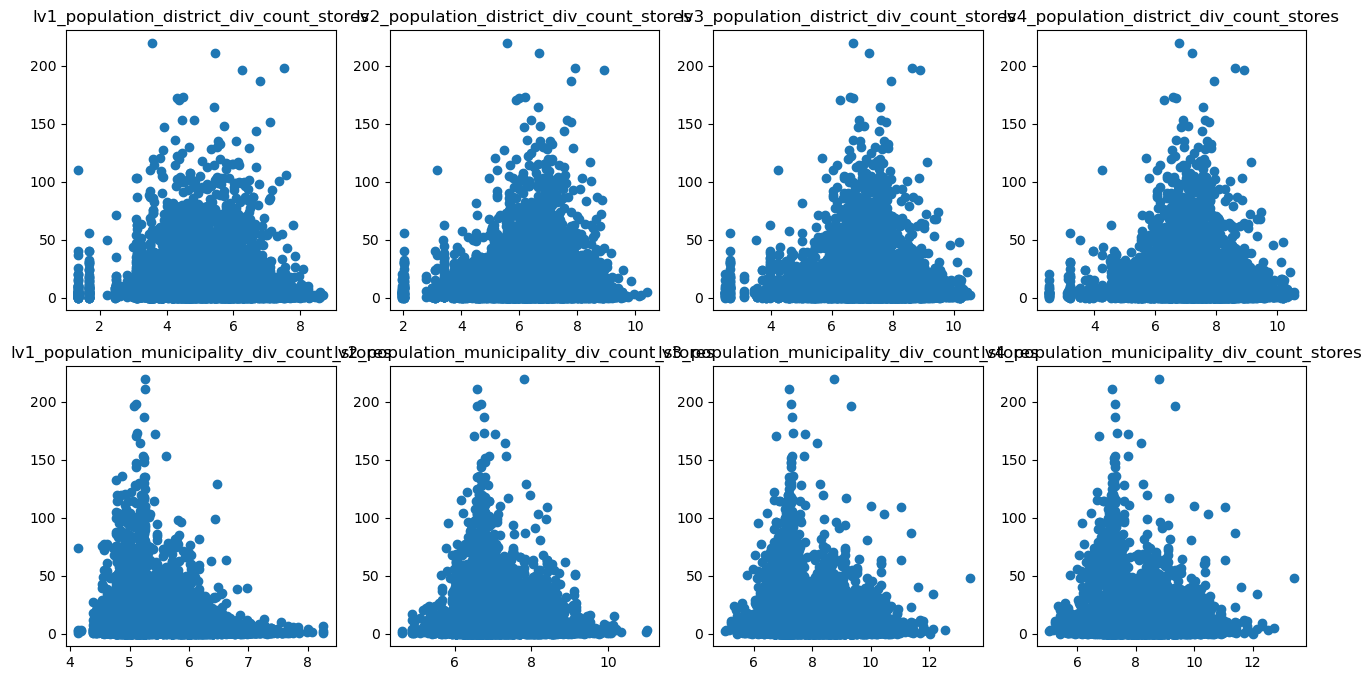

In [ ]:
columns = ["lv1_population_district_div_count_stores", 'lv2_population_district_div_count_stores', 'lv3_population_district_div_count_stores', "lv4_population_district_div_count_stores", 'lv1_population_municipality_div_count_stores', 'lv2_population_municipality_div_count_stores','lv3_population_municipality_div_count_stores','lv4_population_municipality_div_count_stores']
fig, axs = plt.subplots(2,4, figsize=(16,8))

for i, name in enumerate(columns):
    axs[i//4][i%4].scatter(np.log1p(df[name]), df.revenue)
    axs[i//4][i%4].set_title(name)

## Feature importances
See comments in the code cell below.

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's rmse: 1.02462
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.02202
[3]	valid_0's rmse: 1.01945
[4]	valid_0's rmse: 1.01664
[5]	valid_0's rmse: 1.01388
[6]	valid_0's rmse: 1.01144
[7]	valid_0's rmse: 1.00869
[8]	valid_0's rmse: 1.00599
[9]	valid_0's rmse: 1.00362
[10]	valid_0's rmse: 1.00094
[11]	valid_0's rmse: 0.998612
[12]	valid_0's rmse: 0.996485
[13]	valid_0's rmse: 0.993903
[14]	valid_0

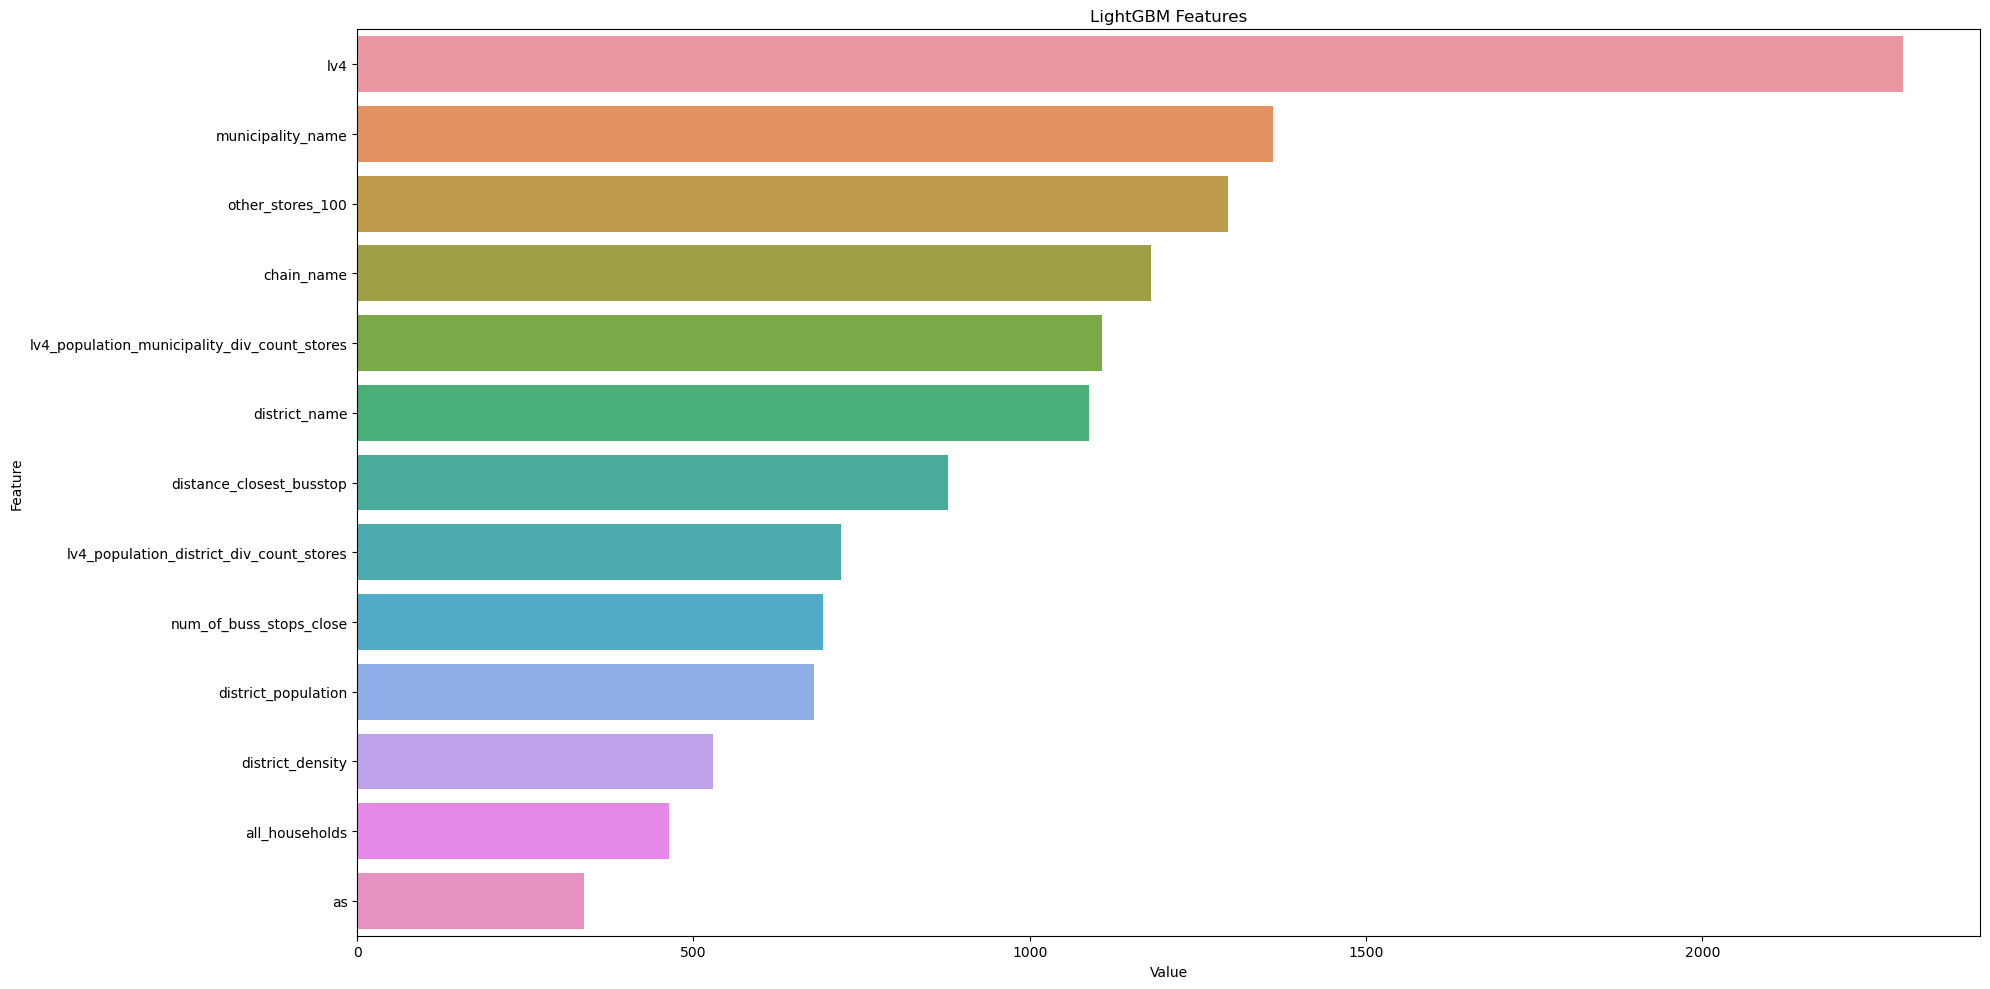

0.7297382004766592


In [ ]:
# Under is one of the initial plots from LightGBM. This plot was made early in the project and when viewing it, we thought that 
# municipality_name and district_name was important features. After tuning which columns to include with optuna, we found out that the features caused overfitting,
# and should be removed. So an experience learned from this is to not just look at the feature importance, but other plots like SHAP and tune wich columns to include.

## SHAP
See the explanation of the autoML model
This is the H2O model used in both the short notebooks. 

### What we get out of the SHAP plot
- Chain name is important and makes a big impact
- The type of shop is important and gives a big impact.
- More LV1 stores in the same category inside the same district will positively correlate with a higher revenue. This can be interpreted as that this is a district where many people shop/visit LV1-stores, and that this is positive since more people visit.
- More LV4 stores in the same category inside the same municipality negatively correlates with a higher revenue. This can mean that competition between equal stores lower the revenue. 

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   rmse        mse       mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-----------------------------------------------------  --------  ---------  --------  --------  ------------------------  ------------------  -------------------------  ------------
XGBoost_grid_1_AutoML_4_20221110_130410_model_96       0.216277  0.0467756  0.154317  0.101107                 0.0467756                 860                   0.002615  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_68       0.238531  0.0568972  0.170266  0.110574                 0.0568972                1323                   0.002353  XGBoost
GBM_grid_1_AutoML_4_20221110_130410_model_8            0.241514  0.058329   0.173364  0.116606                 0.058329                 2605                   0.007642  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_45       0.244317  0.0596908  0.173356  0.11262                  0.0596908                1640                   0.002601  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_67       0.250925  0.0629633  0.176868  0.117349                 0.0629633                1042                   0.002081  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_27       0.253152  0.0640858  0.183333  0.116203                 0.0640858                1161                   0.002656  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_66       0.258103  0.0666172  0.187614  0.11754                  0.0666172                1217                   0.002707  XGBoost
GBM_grid_1_AutoML_4_20221110_130410_model_15           0.260898  0.0680678  0.185701  0.120836                 0.0680678                1307                   0.008181  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_8        0.270546  0.073195   0.188509  0.125978                 0.073195                 1006                   0.002034  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_97       0.292217  0.0853908  0.212984  0.131812                 0.0853908                1279                   0.002476  XGBoost
DeepLearning_grid_2_AutoML_4_20221110_130410_model_39  0.296507  0.0879161  0.204011  0.137479                 0.0879161               32842                   0.027165  DeepLearning
XGBoost_grid_1_AutoML_4_20221110_130410_model_84       0.299095  0.0894577  0.215149  0.137026                 0.0894577                 792                   0.002292  XGBoost
DRF_1_AutoML_4_20221110_130410                         0.31395   0.0985648  0.237481  0.145365                 0.0985648                9264                   0.015048  DRF
GBM_grid_1_AutoML_4_20221110_130410_model_13           0.317274  0.100663   0.242115  0.149432                 0.100663                 2626                   0.007476  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_2        0.318364  0.101356   0.228104  0.141801                 0.101356                  950                   0.003292  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_99       0.321294  0.10323    0.23842   0.144521                 0.10323                   984                   0.002617  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_55       0.341704  0.116762   0.250976  0.152726                 0.116762                 1196                   0.002196  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_40       0.34251   0.117313   0.255982  0.15702                  0.117313                  875                   0.001913  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_33       0.356345  0.126982   0.261583  0.158994                 0.126982                 1046                   0.002089  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_36       0.357146  0.127553   0.265707  0.164082                 0.127553                 1073                   0.001733  XGBoost
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

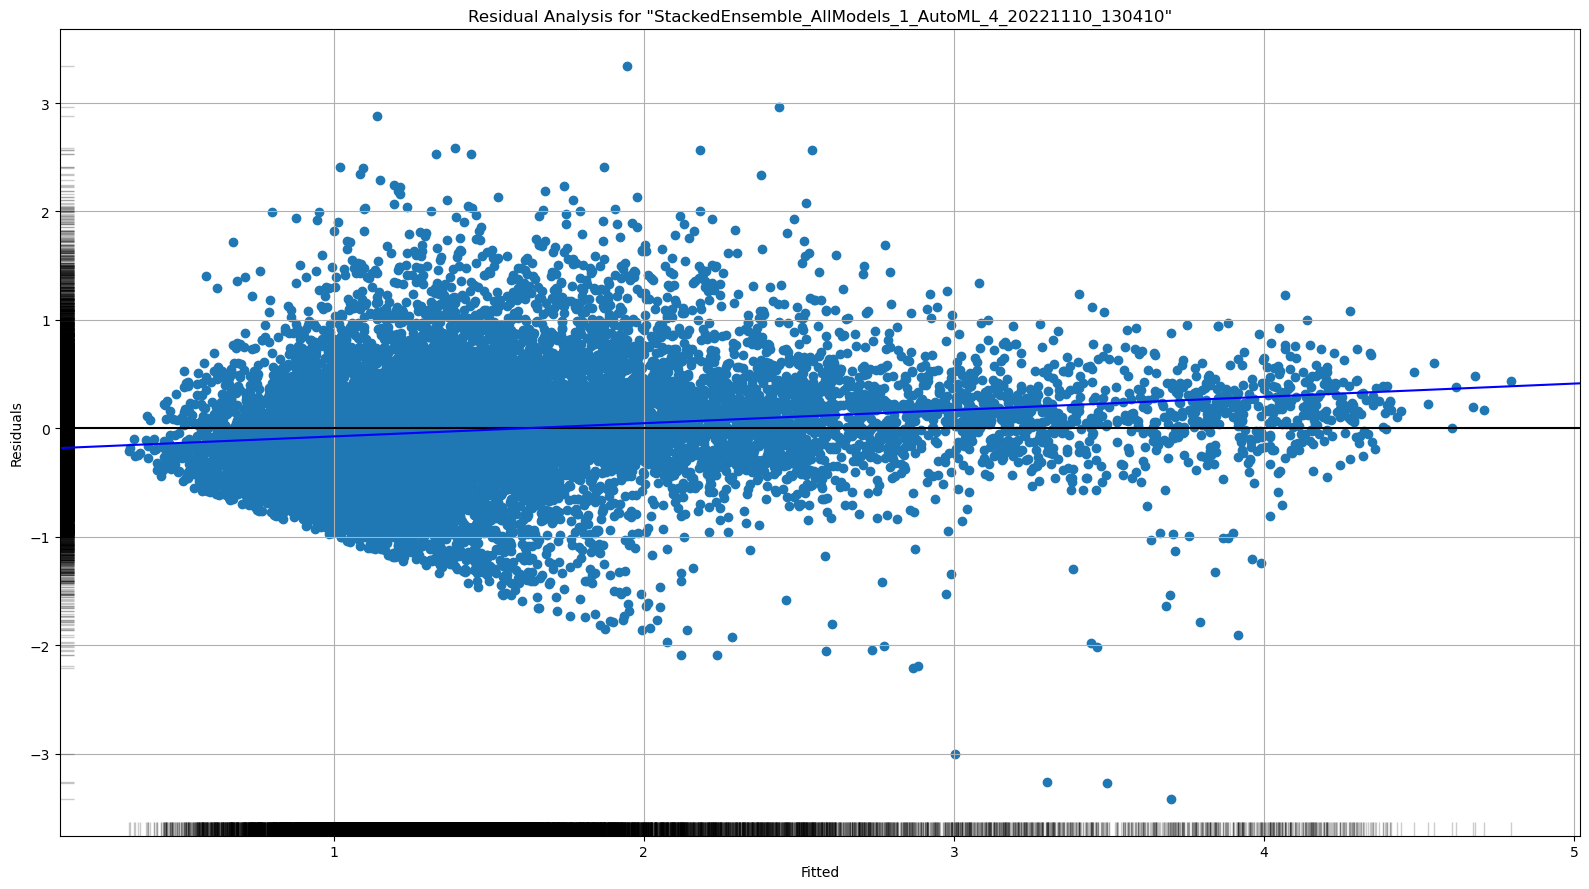

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

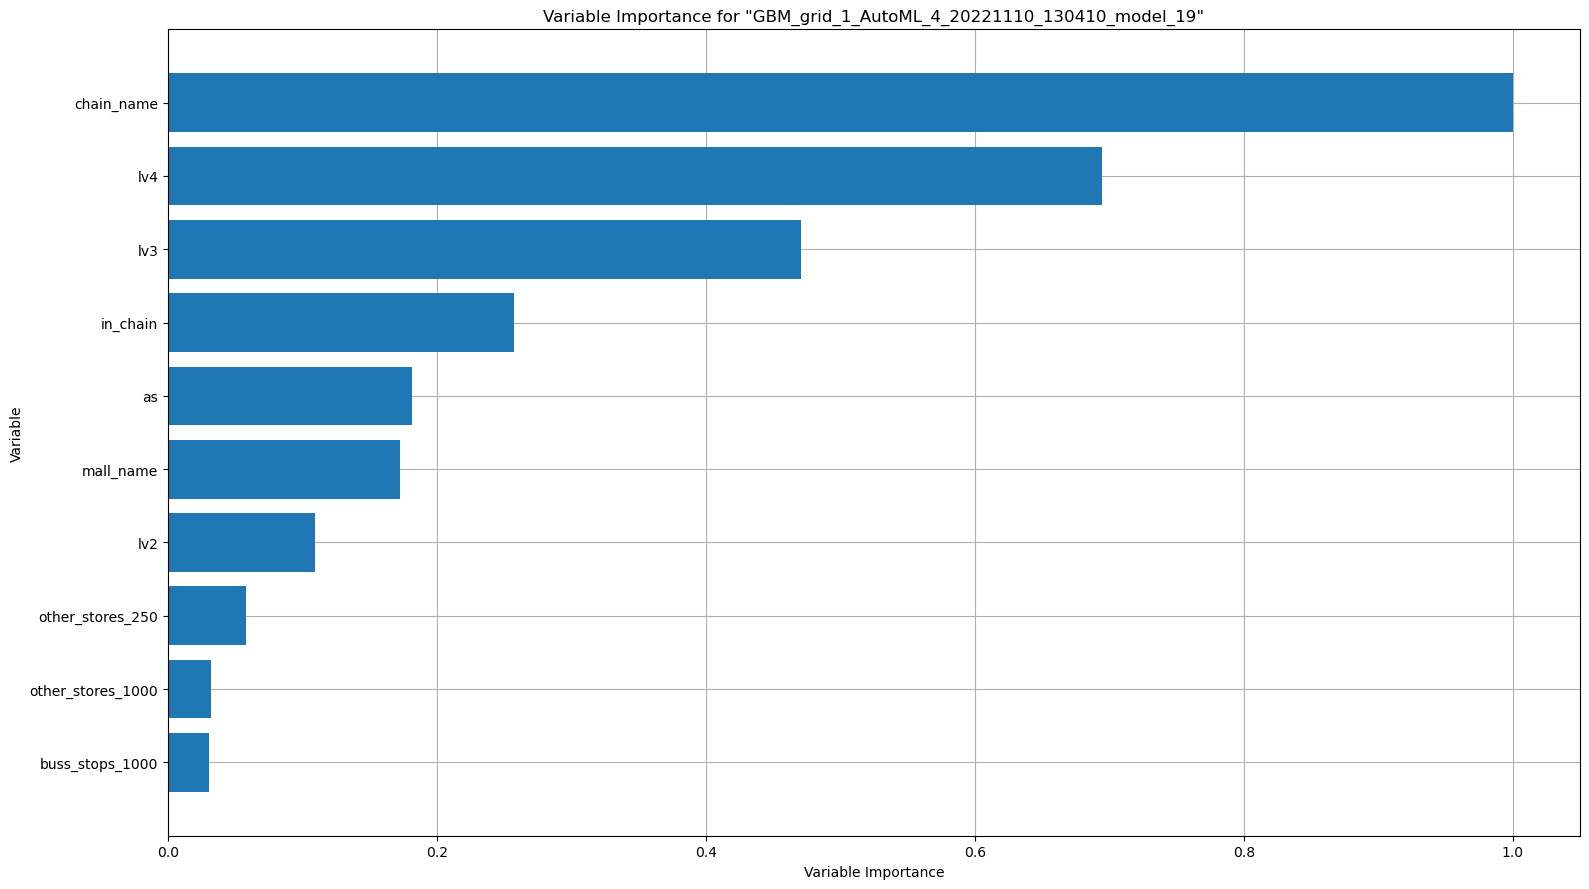

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

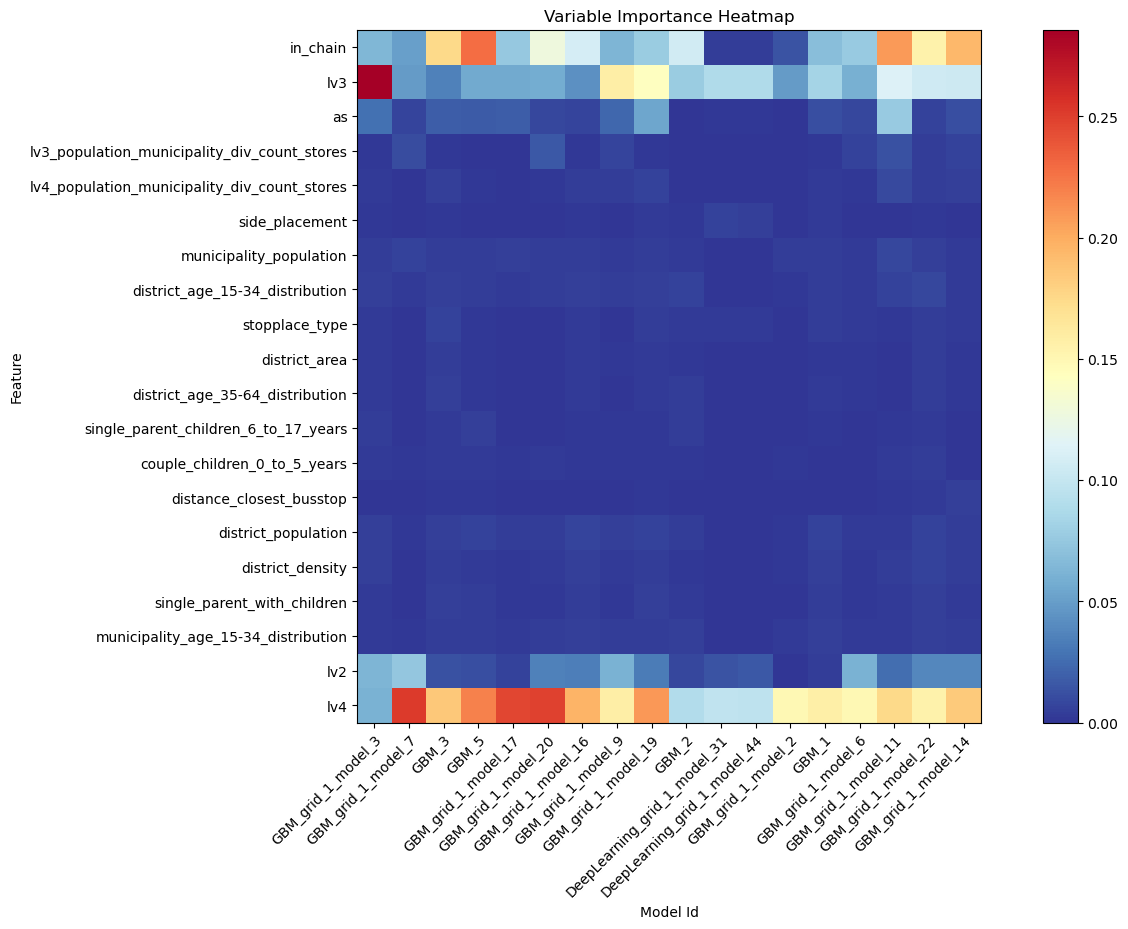

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

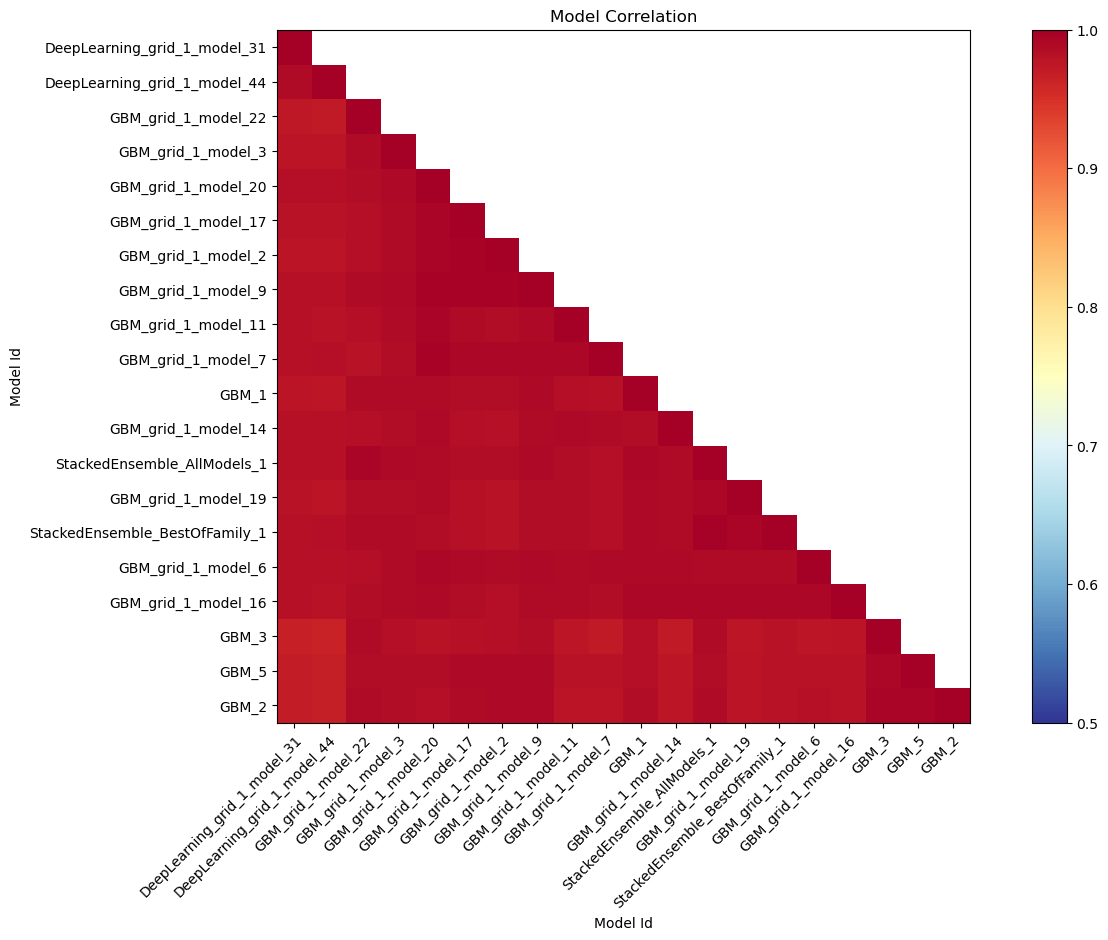

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

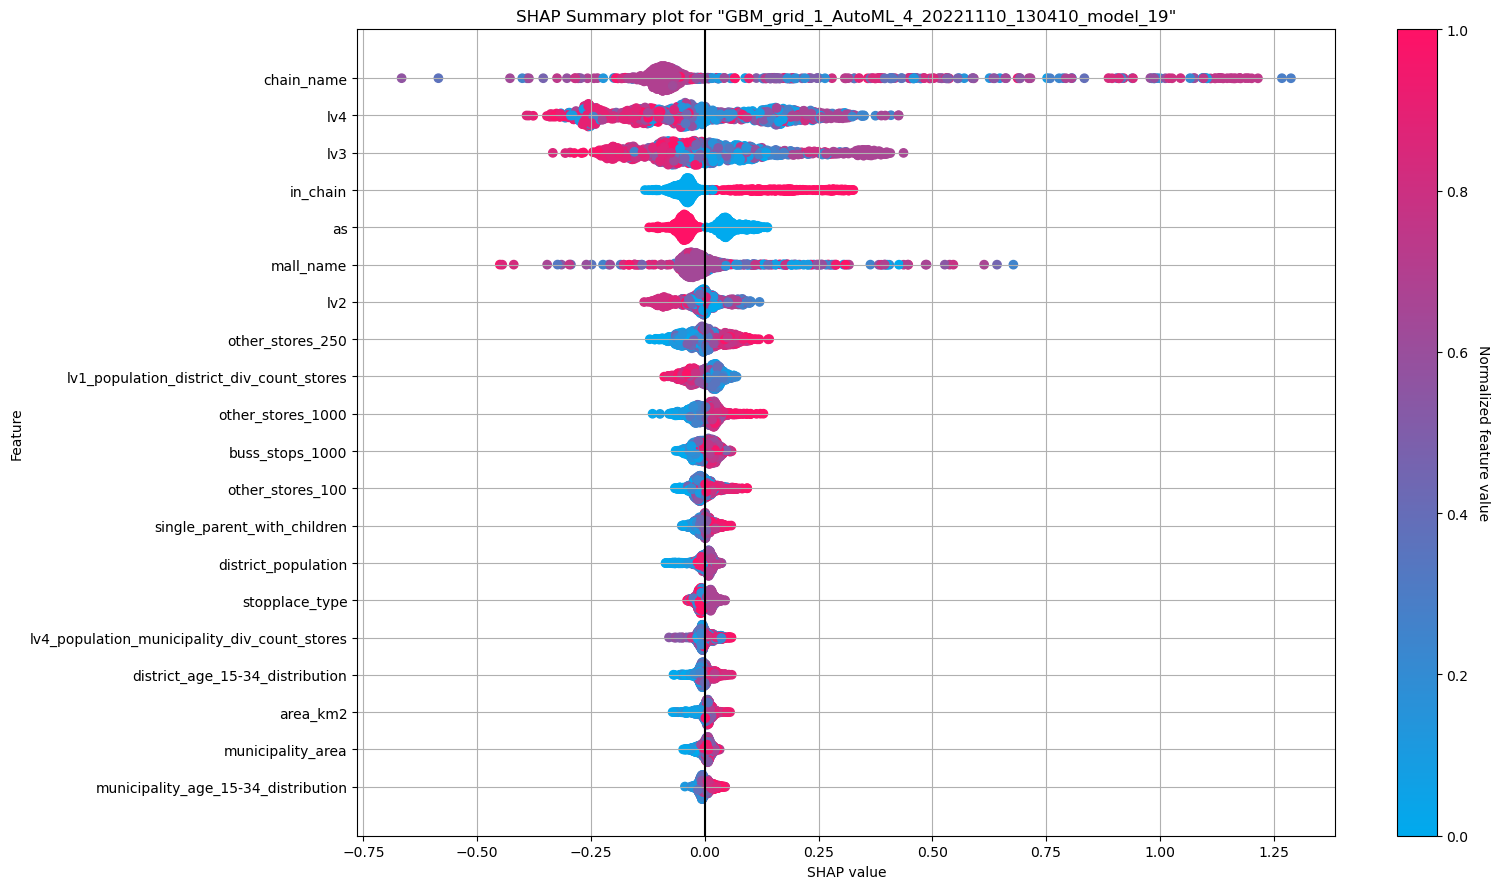

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

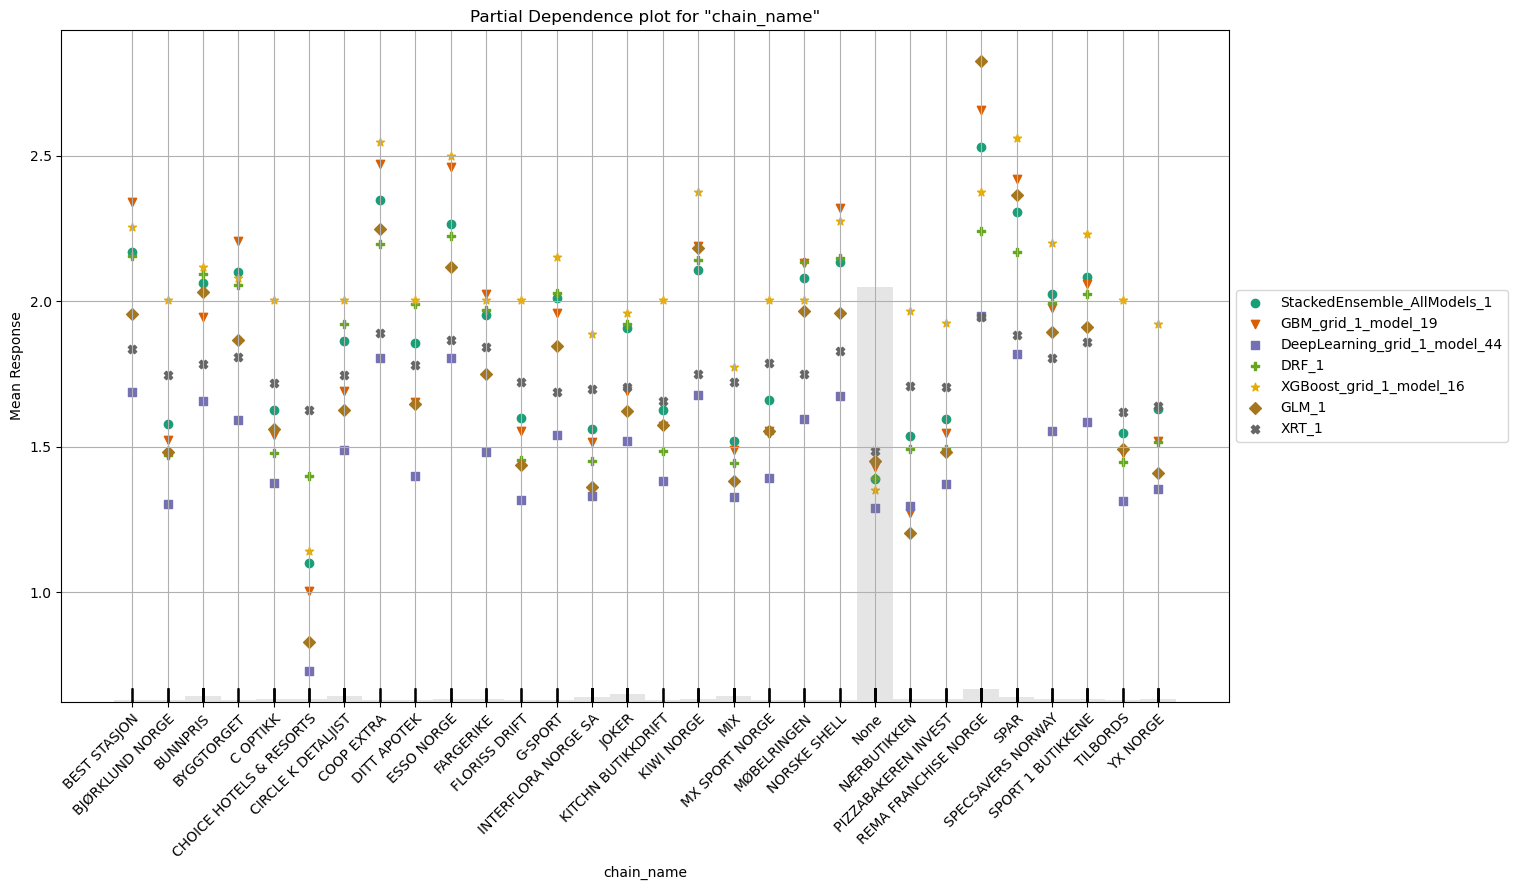

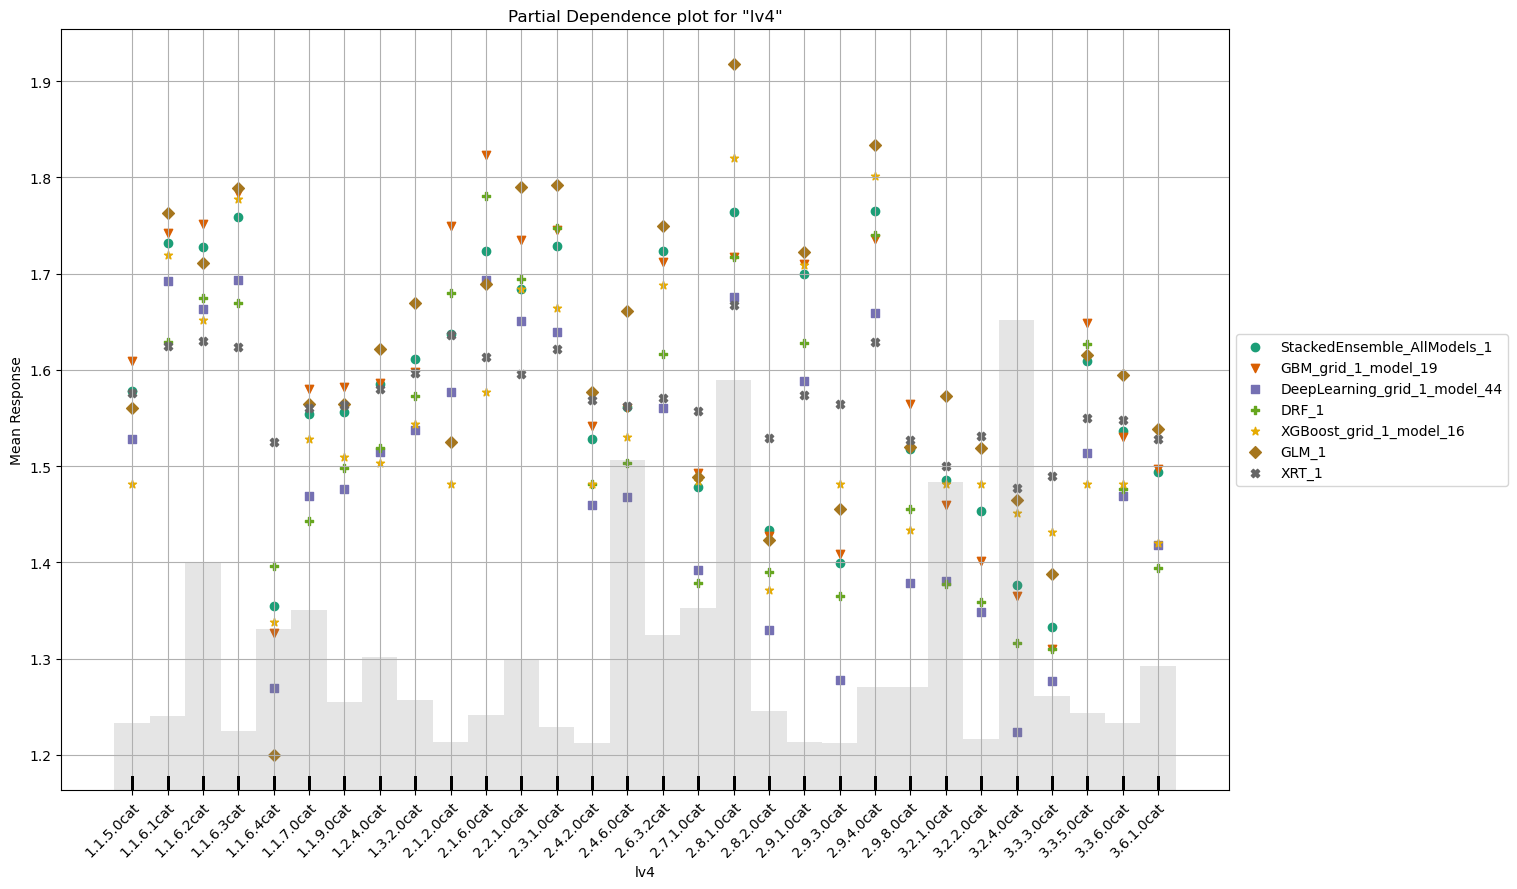

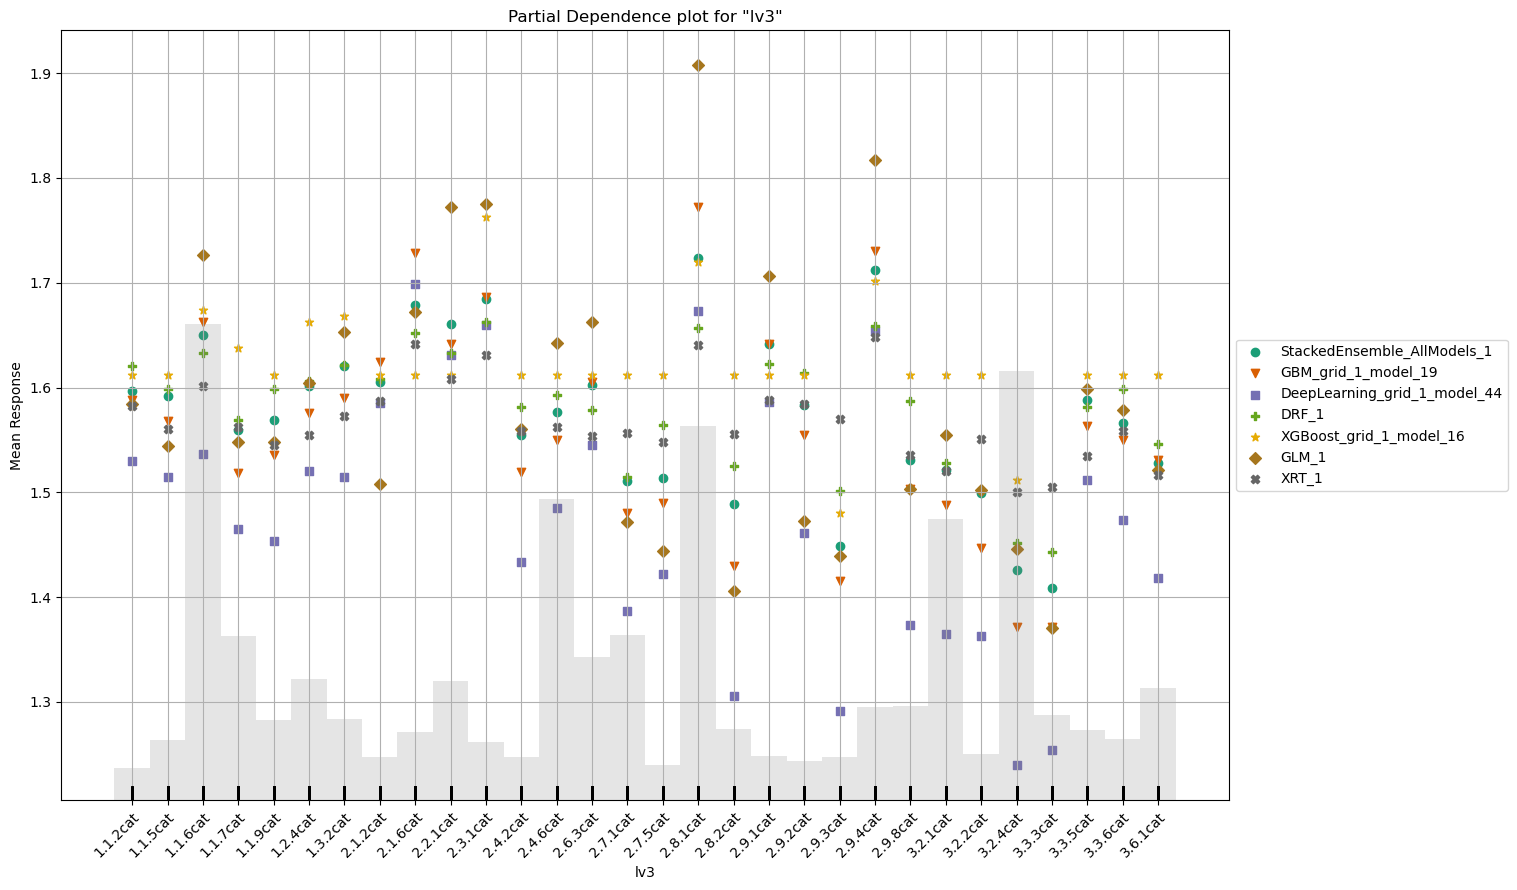

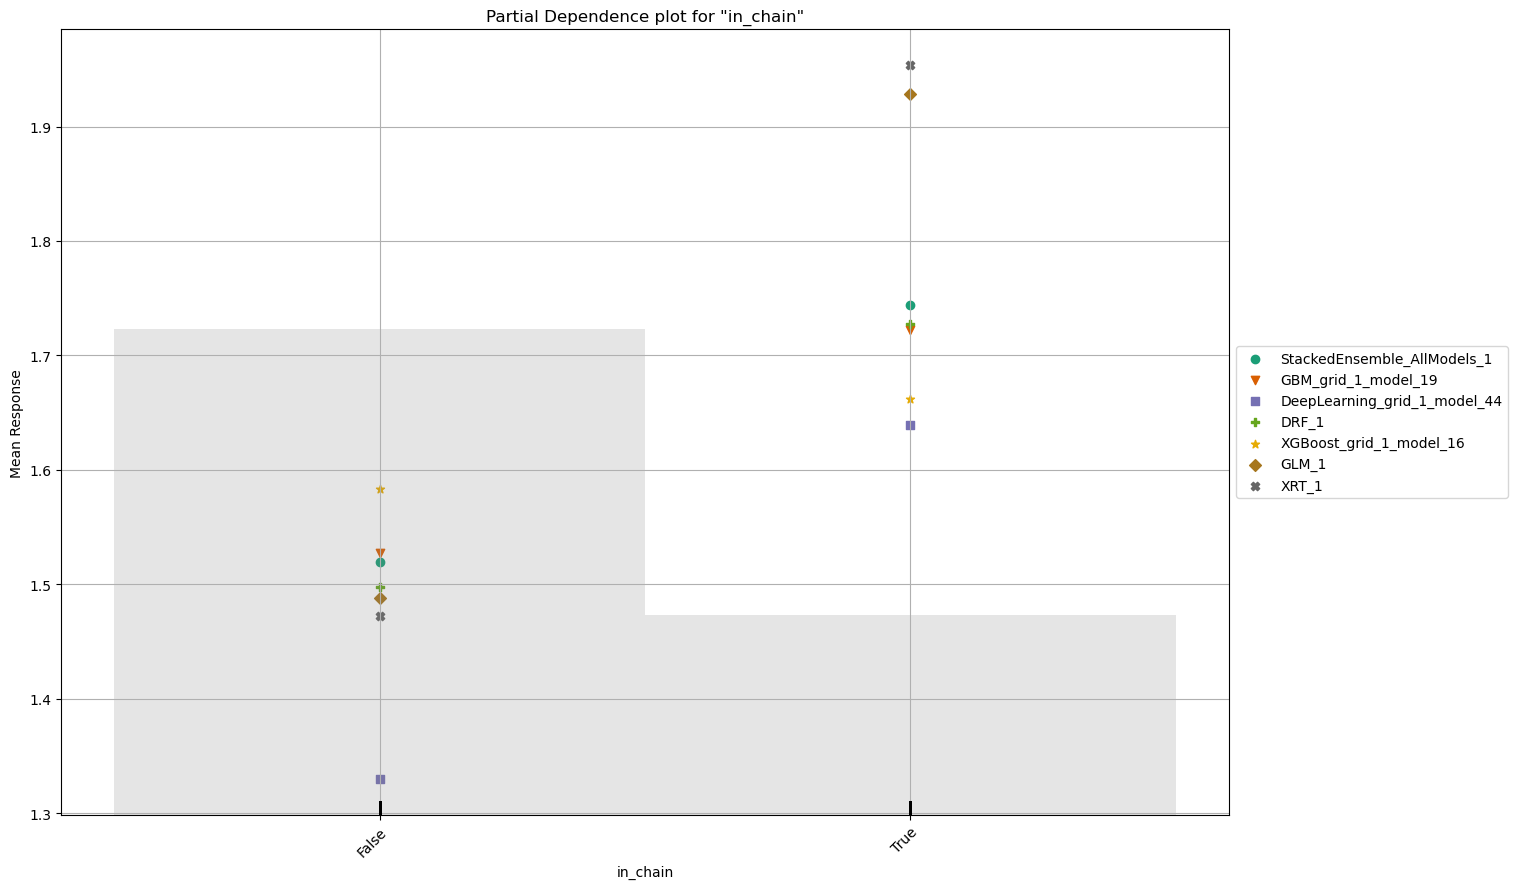

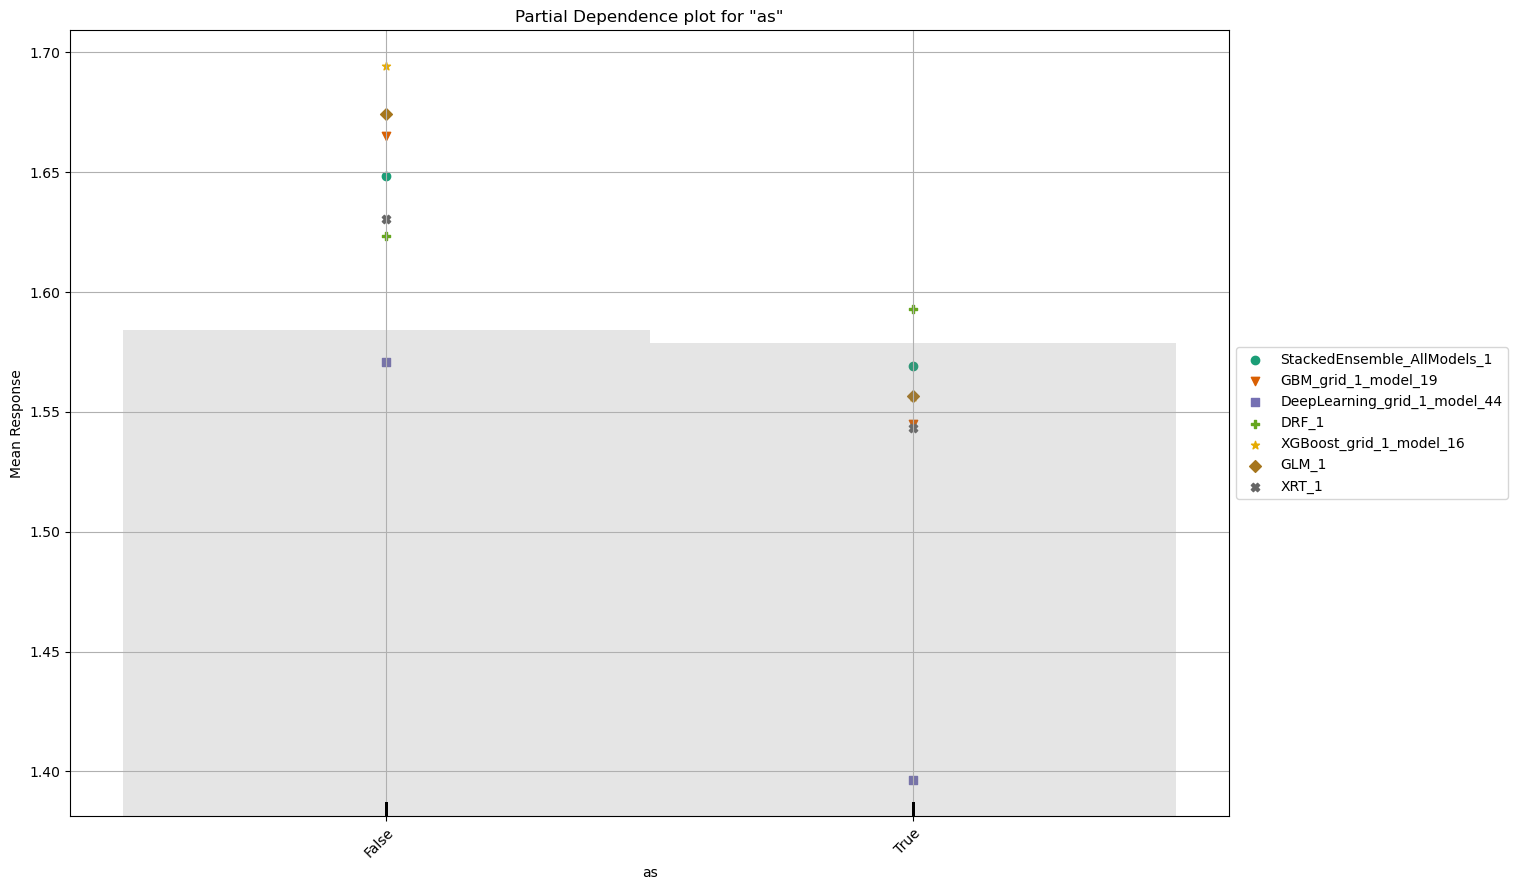

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

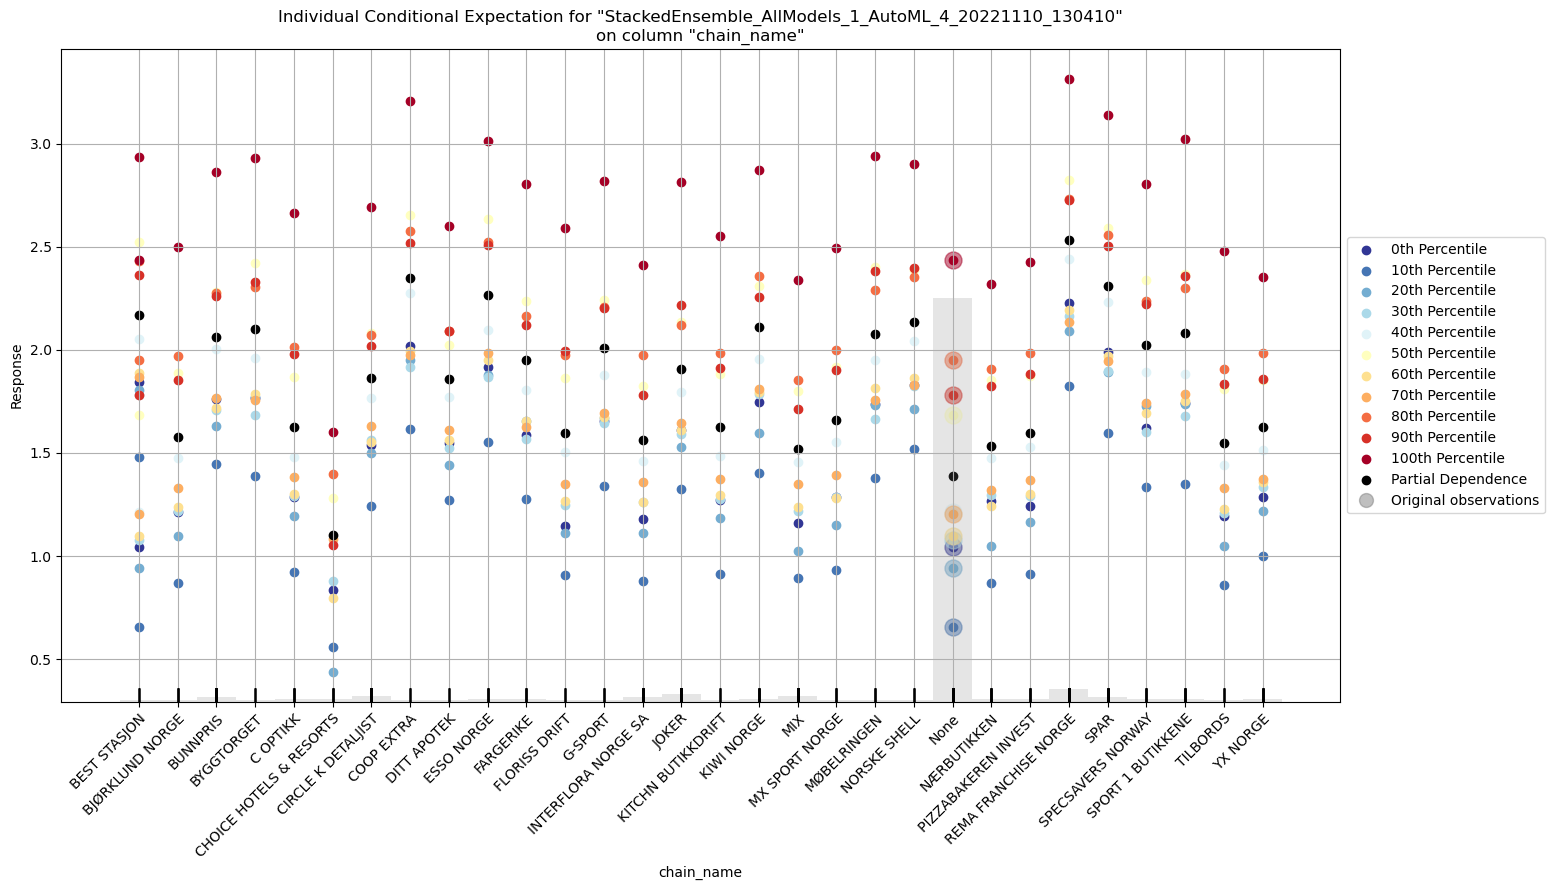

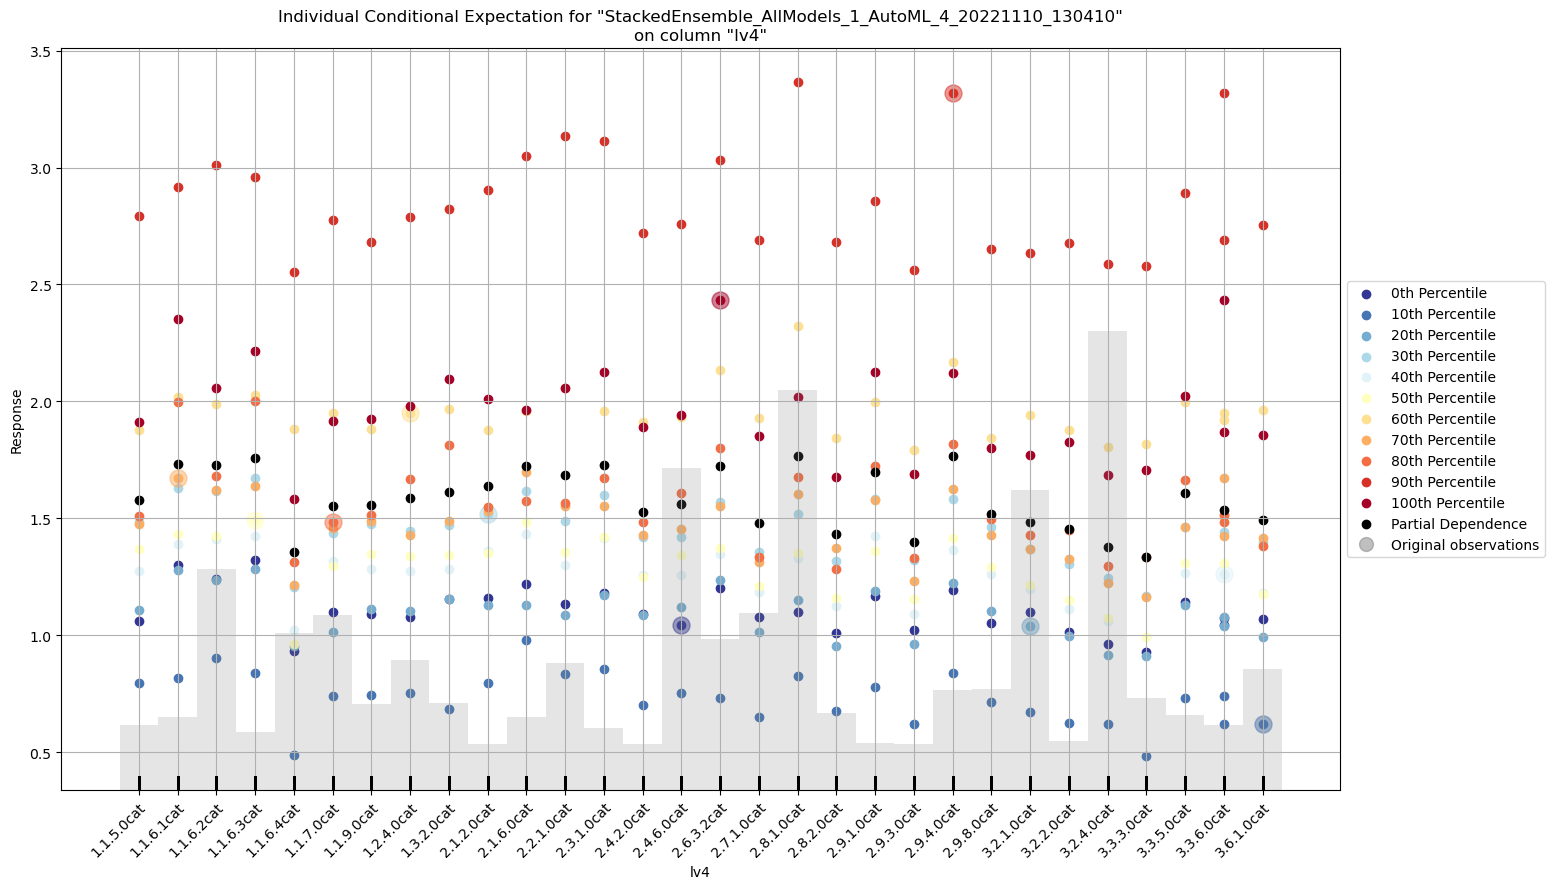

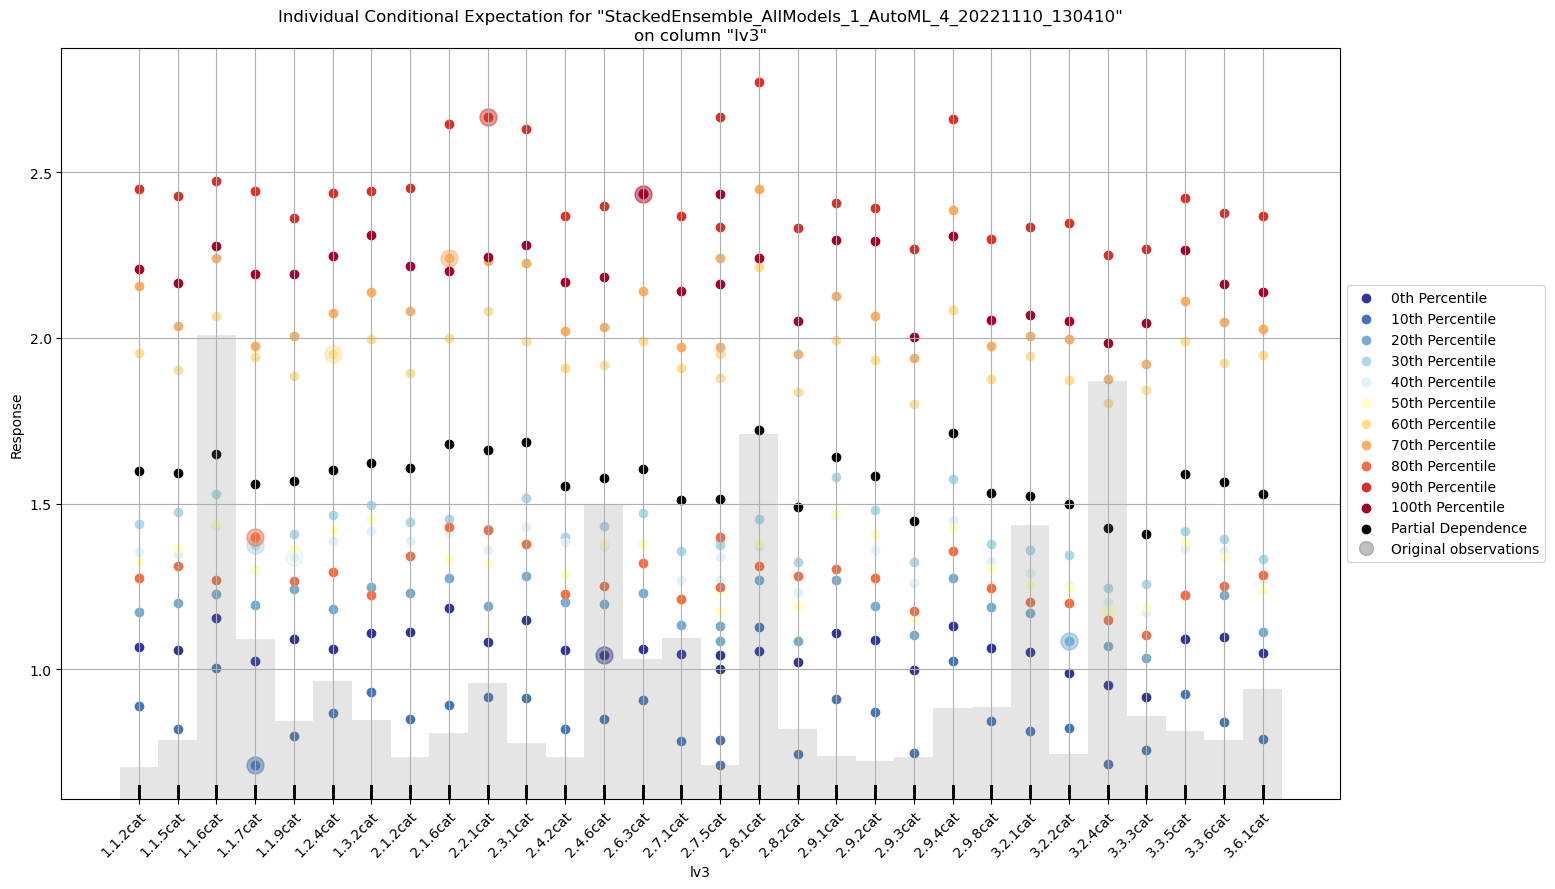

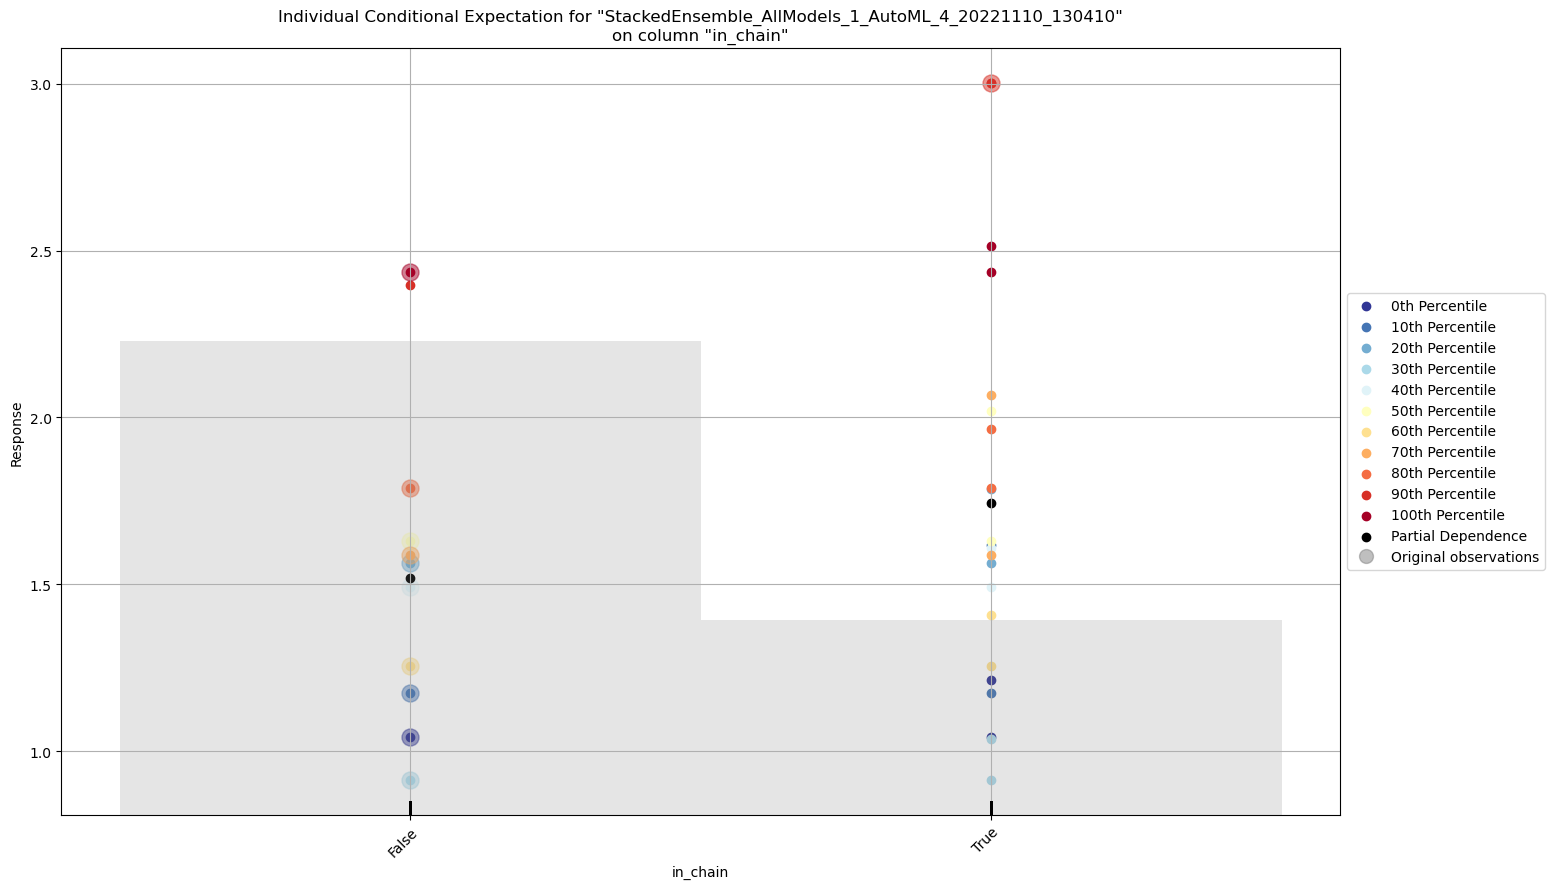

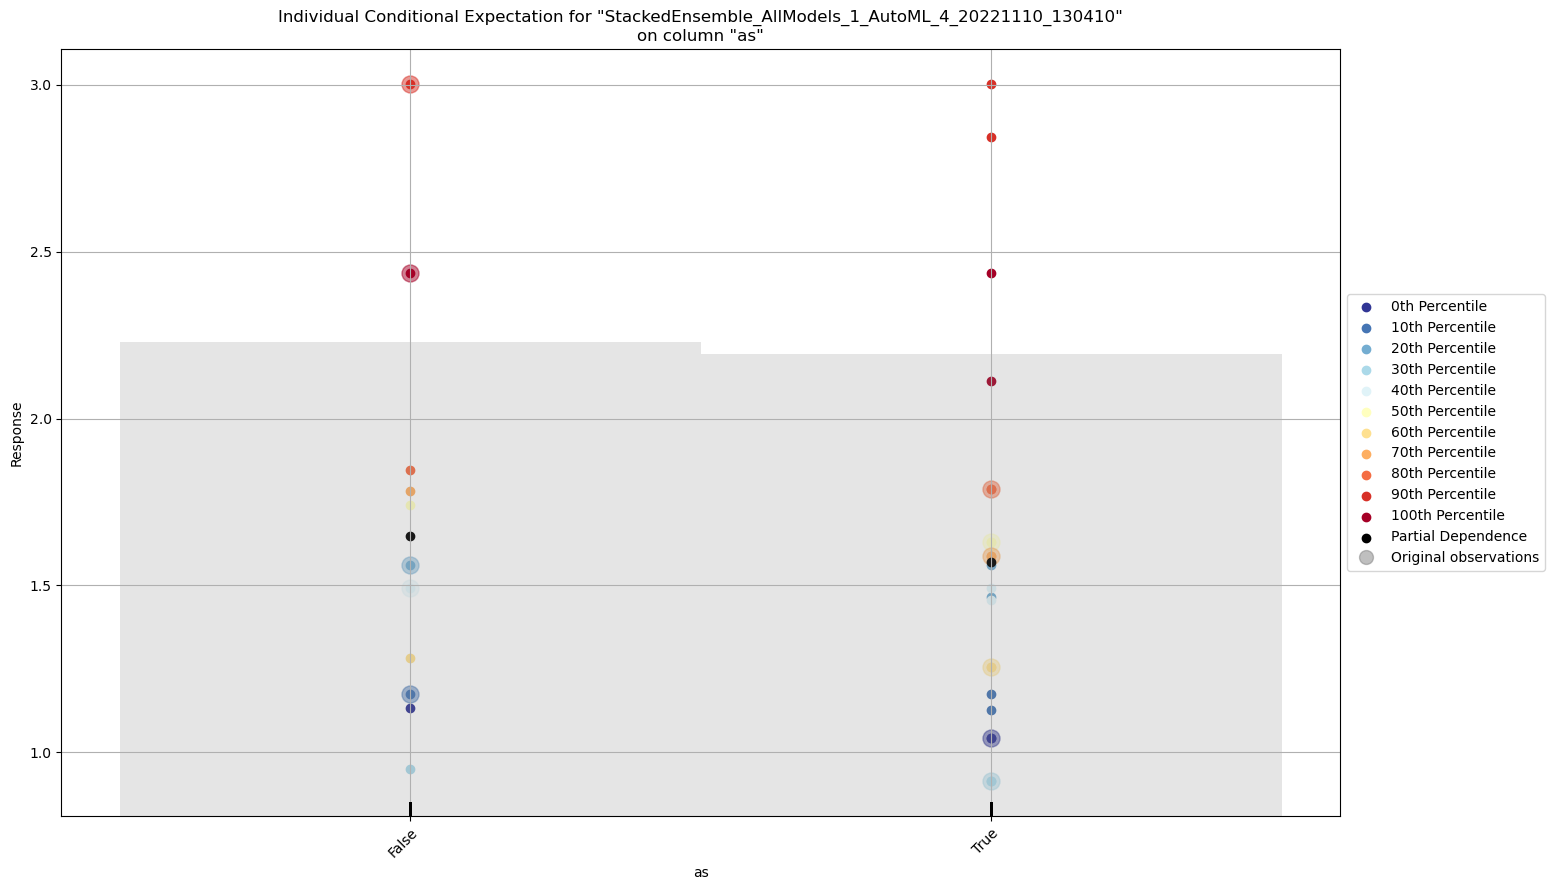

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   rmse        mse       mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-----------------------------------------------------  --------  ---------  --------  --------  ------------------------  ------------------  -------------------------  ------------
XGBoost_grid_1_AutoML_4_20221110_130410_model_96       0.216277  0.0467756  0.154317  0.101107                 0.0467756                 860                   0.002615  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_68       0.238531  0.0568972  0.170266  0.110574                 0.0568972                1323                   0.002353  XGBoost
GBM_grid_1_AutoML_4_20221110_130410_model_8            0.241514  0.058329   0.173364  0.116606                 0.058329                 2605                   0.007642  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_45       0.244317  0.0596908  0.173356  0.11262                  0.0596908                1640                   0.002601  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_67       0.250925  0.0629633  0.176868  0.117349                 0.0629633                1042                   0.002081  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_27       0.253152  0.0640858  0.183333  0.116203                 0.0640858                1161                   0.002656  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_66       0.258103  0.0666172  0.187614  0.11754                  0.0666172                1217                   0.002707  XGBoost
GBM_grid_1_AutoML_4_20221110_130410_model_15           0.260898  0.0680678  0.185701  0.120836                 0.0680678                1307                   0.008181  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_8        0.270546  0.073195   0.188509  0.125978                 0.073195                 1006                   0.002034  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_97       0.292217  0.0853908  0.212984  0.131812                 0.0853908                1279                   0.002476  XGBoost
DeepLearning_grid_2_AutoML_4_20221110_130410_model_39  0.296507  0.0879161  0.204011  0.137479                 0.0879161               32842                   0.027165  DeepLearning
XGBoost_grid_1_AutoML_4_20221110_130410_model_84       0.299095  0.0894577  0.215149  0.137026                 0.0894577                 792                   0.002292  XGBoost
DRF_1_AutoML_4_20221110_130410                         0.31395   0.0985648  0.237481  0.145365                 0.0985648                9264                   0.015048  DRF
GBM_grid_1_AutoML_4_20221110_130410_model_13           0.317274  0.100663   0.242115  0.149432                 0.100663                 2626                   0.007476  GBM
XGBoost_grid_1_AutoML_4_20221110_130410_model_2        0.318364  0.101356   0.228104  0.141801                 0.101356                  950                   0.003292  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_99       0.321294  0.10323    0.23842   0.144521                 0.10323                   984                   0.002617  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_55       0.341704  0.116762   0.250976  0.152726                 0.116762                 1196                   0.002196  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_40       0.34251   0.117313   0.255982  0.15702                  0.117313                  875                   0.001913  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_33       0.356345  0.126982   0.261583  0.158994                 0.126982                 1046                   0.002089  XGBoost
XGBoost_grid_1_AutoML_4_20221110_130410_model_36       0.357146  0.127553   0.265707  0.164082                 0.127553                 1073                   0.001733  XGBoost
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [ ]:
aml.explain(hf) 

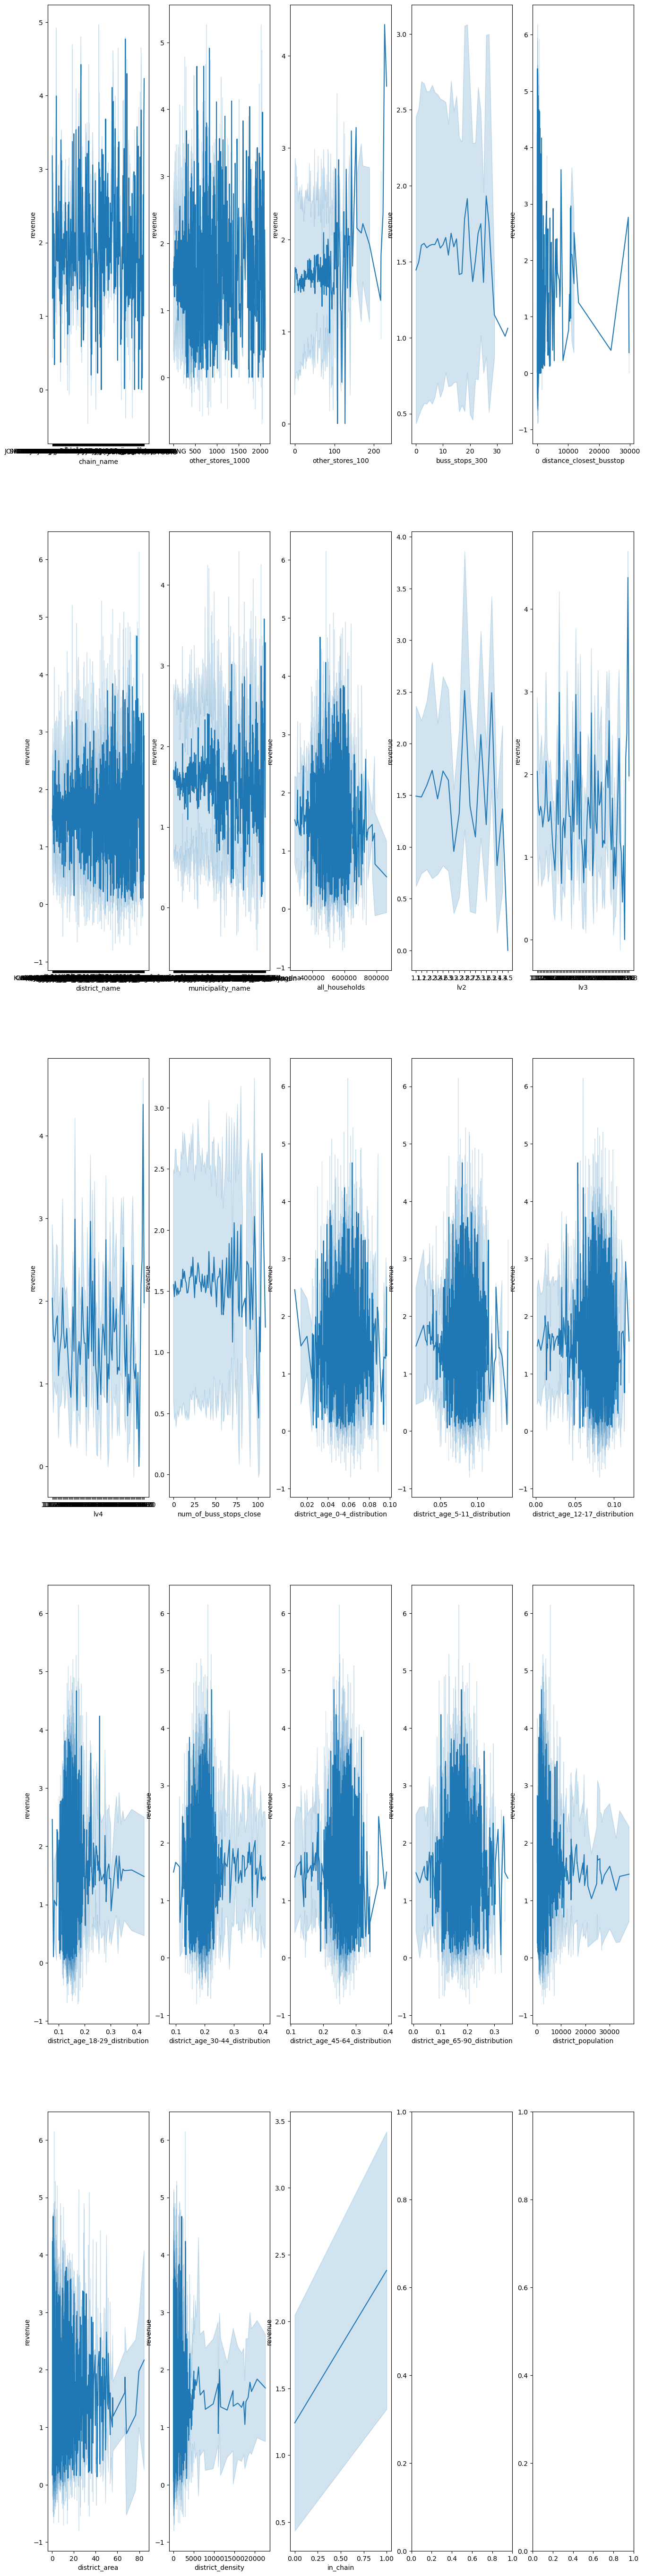

In [ ]:
import math
fig, axs = plt.subplots(nrows=math.ceil(len(list(X.columns.to_numpy()))/5), ncols=5, figsize=(16, 70))
for (i, col) in enumerate(X.columns):
    sns.lineplot(x=X[col], y=y_scaled, errorbar="sd", ax=axs[math.floor(i/5)][i%5])

## More exploration of individual features
In addition to plotting and looking at distributions, we also used correlations to quickly see that some features could be quickly removed from the dataset used for prediction, like the store_name since it correlated 100% with revenue due to unique names.

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


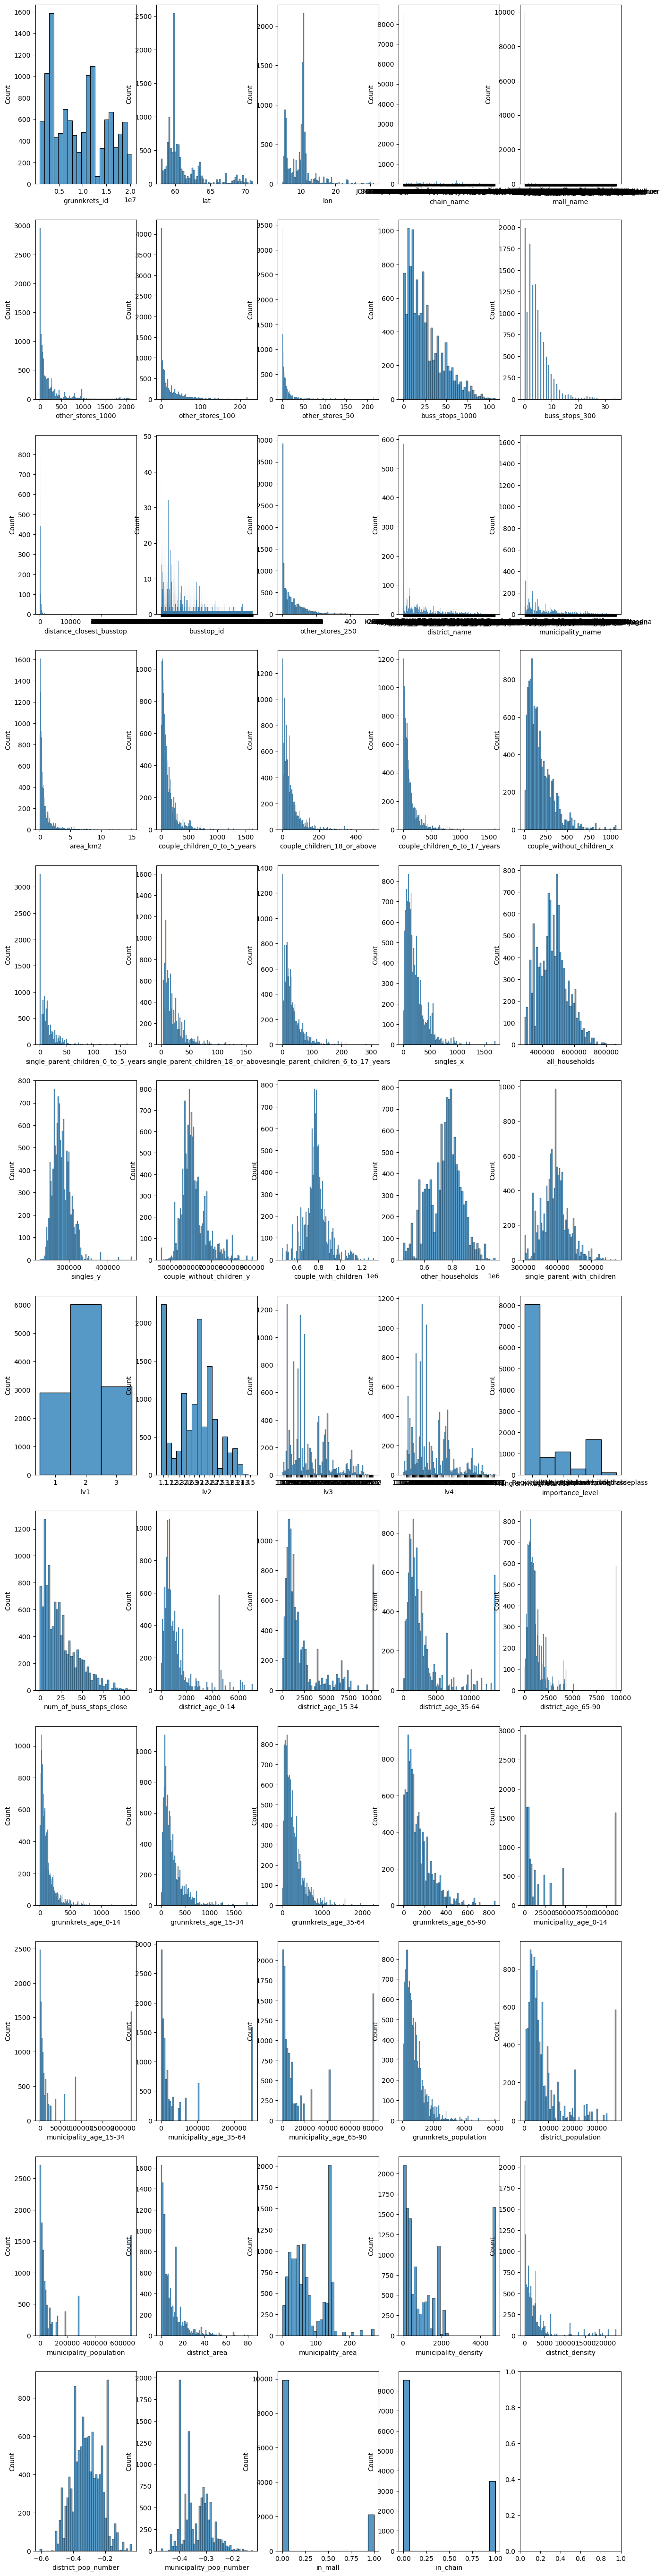

In [ ]:
import math
fig, axs = plt.subplots(nrows=math.ceil(len(list(X.columns.to_numpy()))/5), ncols=5, figsize=(16, 70))
for (i, col) in enumerate(X.columns):
    sns.histplot(X[col], ax=axs[math.floor(i/5)][i%5])

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\dython\nominal.py:289: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


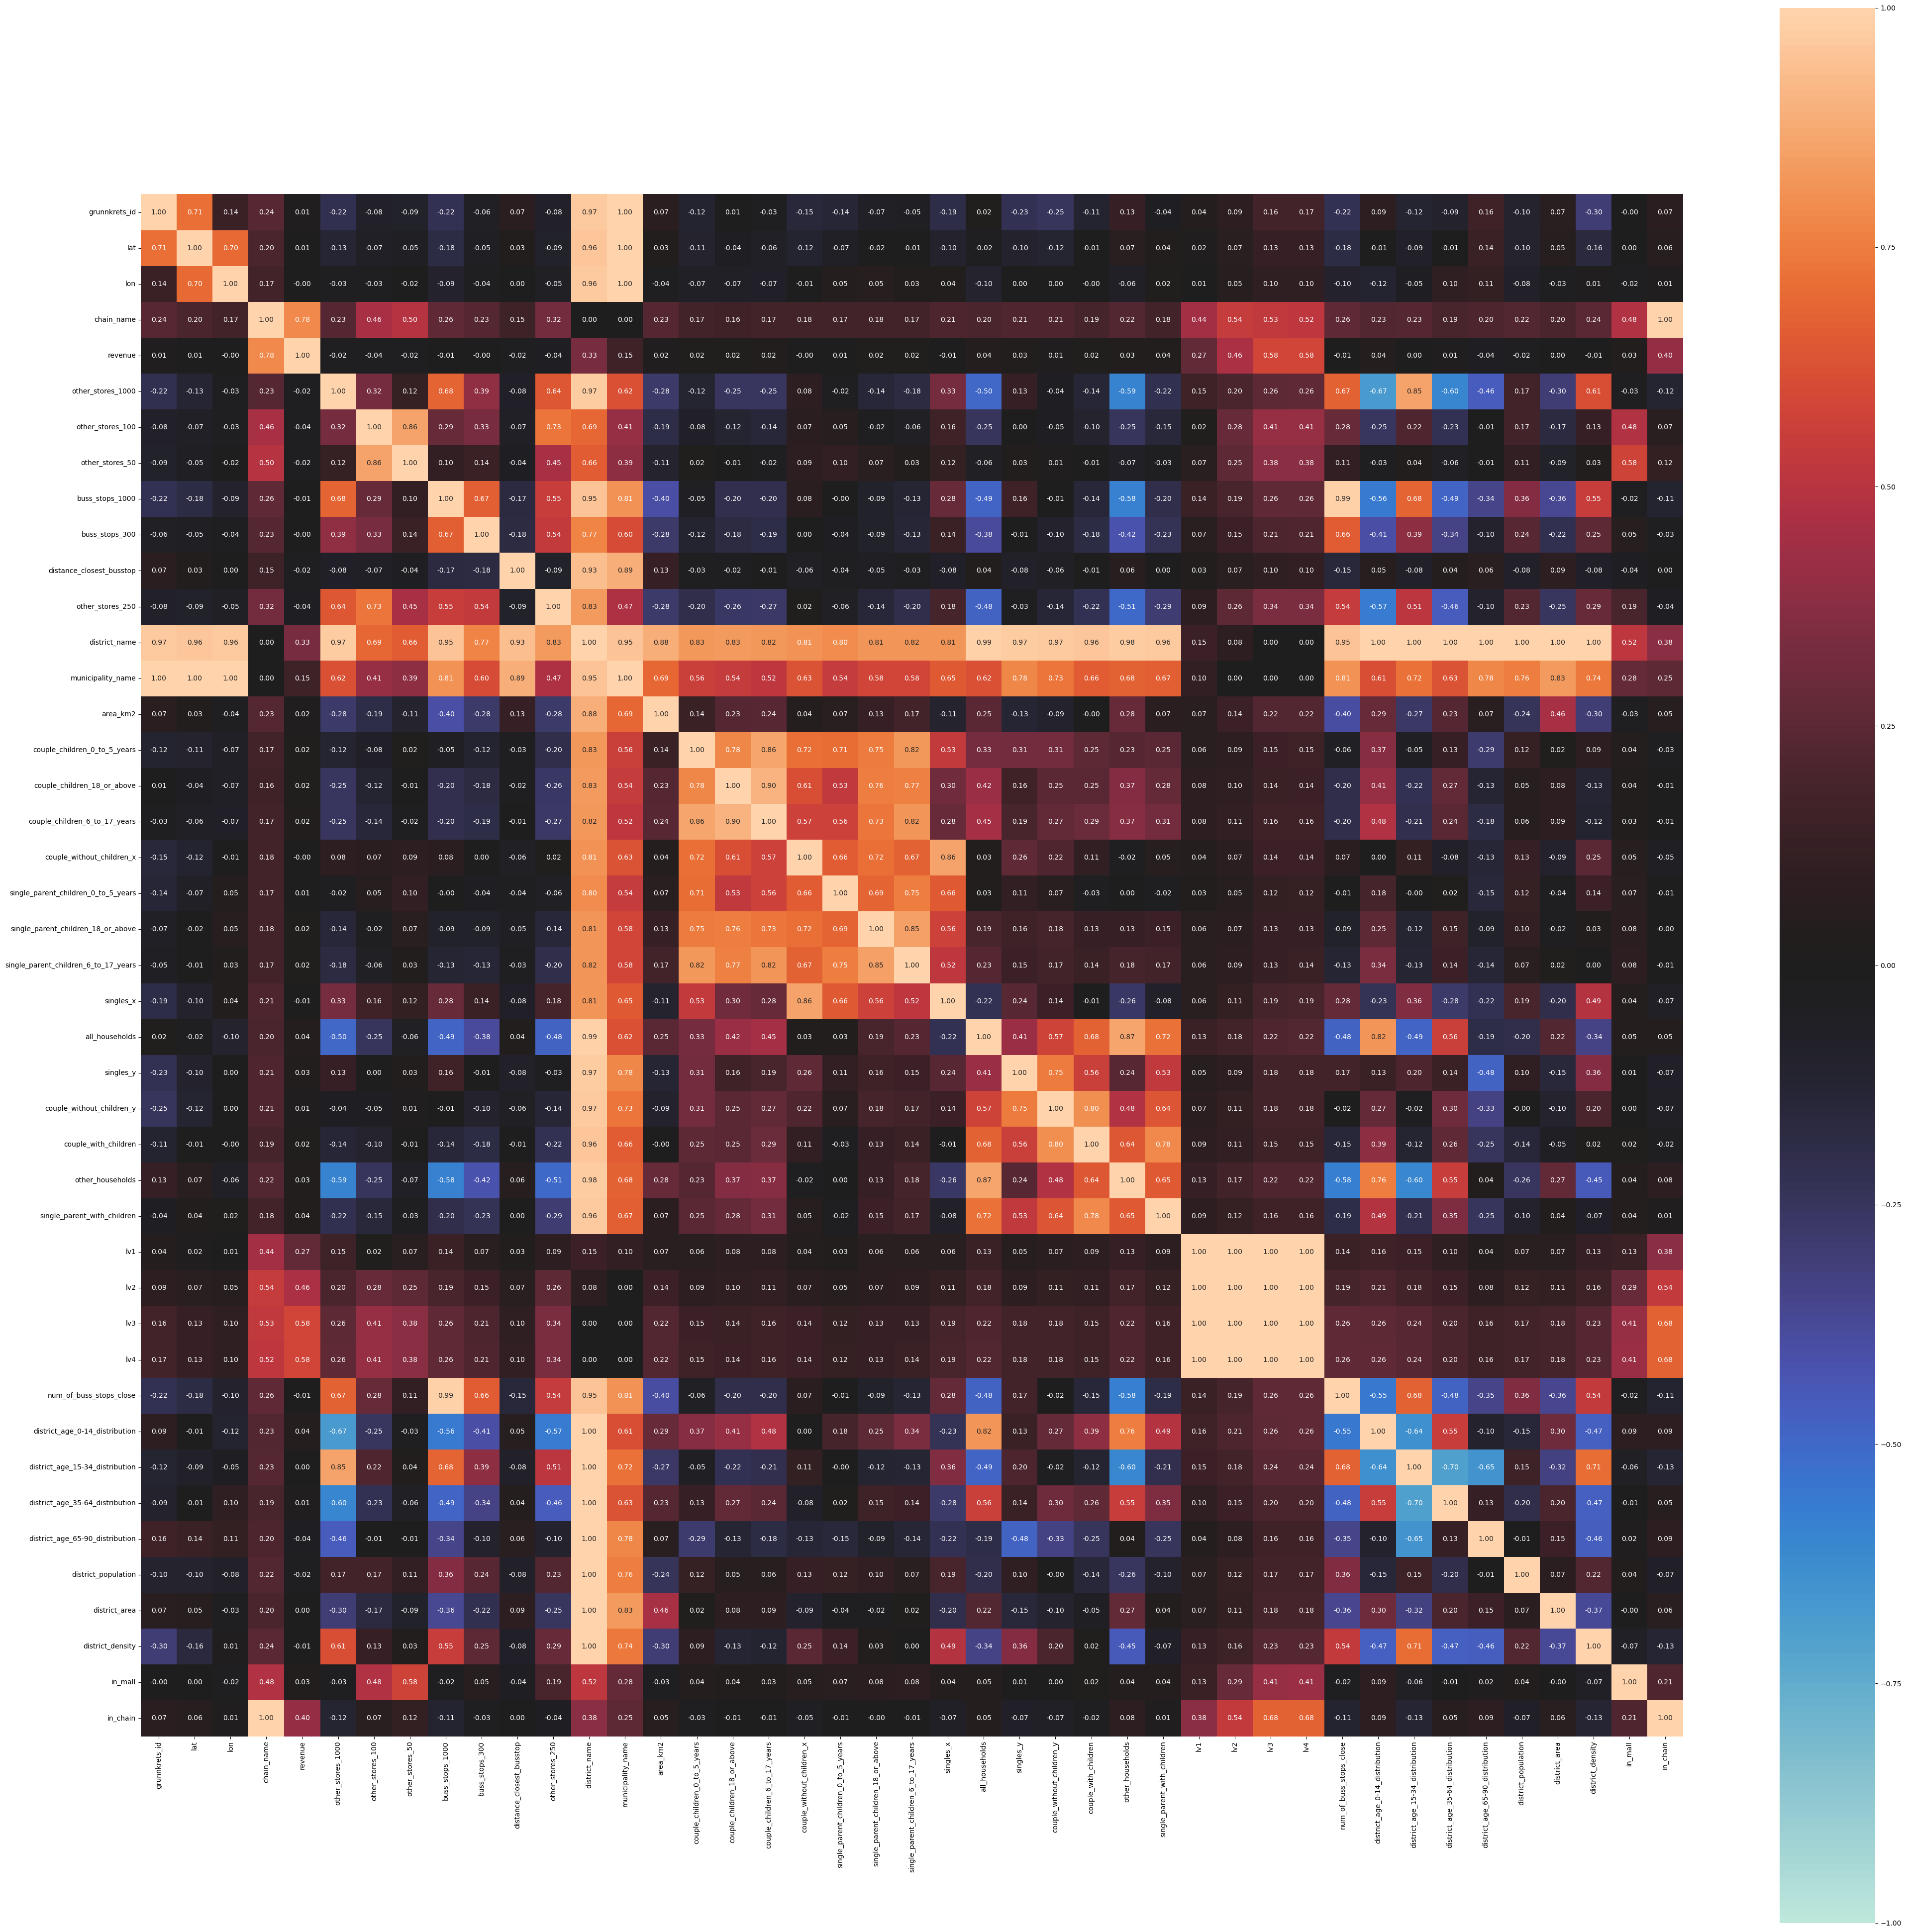

{'corr':                                       grunnkrets_id       lat       lon  \
 grunnkrets_id                              1.000000  0.713542  0.138201   
 lat                                        0.713542  1.000000  0.698669   
 lon                                        0.138201  0.698669  1.000000   
 chain_name                                 0.236595  0.200474  0.165804   
 revenue                                    0.014154  0.007474 -0.001296   
 other_stores_1000                         -0.216529 -0.131866 -0.026944   
 other_stores_100                          -0.084857 -0.068830 -0.031672   
 other_stores_50                           -0.090222 -0.051333 -0.015401   
 buss_stops_1000                           -0.224127 -0.182678 -0.093918   
 buss_stops_300                            -0.059177 -0.047422 -0.038236   
 distance_closest_busstop                   0.070796  0.029743  0.003673   
 other_stores_250                          -0.078296 -0.088139 -0.054733   
 dis

In [ ]:
from dython.nominal import associations
associations(data_with_label, filename="../../figs/eda/stores_train_correlations_all_everything_low_income.png", figsize=(50,50))
